# 2D Acoustic Wave
---
- Model Setup: [this link](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/01_modelling.ipynb)

- target: $c(x, z)$.

- rescaling: $x' = x/1000, z' = z/1000, t' = t/1000$.

---

# Fixed inverse problem; 

In [1]:
NAME = "0723_combination_fix_inverse"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

# layers = [3, 128, 128, 128, 128, 1] # (x, z, t) -> p
# c = 10.0
# w0 = 100.0
lambda_0 = 0
# direct_params = init_siren_params(random.PRNGKey(0), layers, c, w0)

direct_NAME = "0722_direct_problem_without_source"
direct_iteration = 10000
# direct_NAME = NAME
# direct_iteration = 220000
direct_params = np.load("models/{}/iteration_{}/params.npy".format(direct_NAME, direct_iteration), allow_pickle=True)
direct_params = [[jnp.asarray(arr) for arr in Arr] for Arr in direct_params]


inverse_NAME = "0722_pretrain_inverse_problem"
inverse_iteration = 1000000
inverse_params = np.load("models/{}/inverse_model/iteration_{}/params.npy".format(inverse_NAME, inverse_iteration), allow_pickle=True)
inverse_params = [[jnp.asarray(arr) for arr in Arr] for Arr in inverse_params]

@jax.jit
def scalar_direct_model(params, x, z, t):
	x_ = jnp.hstack([x, z, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

@jax.jit
def scalar_inverse_model(params, x, z):
	x_ = jnp.hstack([x, z])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))
inverse_model = jax.jit(jax.vmap(scalar_inverse_model, in_axes = (None, 0, 0)))

In [4]:
@jax.jit
def mae(pred, true):
	return jnp.mean(jnp.abs(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_dp_dx(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, z, t))

@jax.jit
def scalar_dp_dz(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, z, t))

@jax.jit
def scalar_dp_dt(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, z, t))

@jax.jit
def dp_dxx(params, x, z, t):
    return jax.grad(scalar_dp_dx, 1)(params, x, z, t)

@jax.jit
def dp_dzz(params, x, z, t):
    return jax.grad(scalar_dp_dz, 2)(params, x, z, t)

@jax.jit
def dp_dtt(params, x, z, t):
    return jax.grad(scalar_dp_dt, 3)(params, x, z, t)

@jax.jit
def loss_fn_(direct_params, inverse_params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
    
	c = inverse_model(inverse_params, collocation.x, collocation.z)
	dp_dtt_ = dp_dtt(direct_params, collocation.x, collocation.z, collocation.t)
	dp_dxx_ = dp_dxx(direct_params, collocation.x, collocation.z, collocation.t)
	dp_dzz_ = dp_dzz(direct_params, collocation.x, collocation.z, collocation.t)
	p_pred = direct_model(direct_params, dirichlet.x, dirichlet.z, dirichlet.t).reshape((-1, 1))
	
	loss_c = mae(dp_dtt_ - c**2*(dp_dxx_ + dp_dzz_), 0)
	loss_d = mae(p_pred, dirichlet.p)
	return loss_c, loss_d

@jax.jit
def loss_fn(direct_params, inverse_params, batch):
	loss_c, loss_d = loss_fn_(direct_params, inverse_params, batch)
	return batch["weight"].c*loss_c + batch["weight"].d*loss_d + l2_regularization(direct_params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	direct_params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(direct_params, inverse_params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(direct_params, inverse_params, batch):
	loss_c, loss_d = loss_fn_(direct_params, inverse_params, batch)
	return batch["weight"].c*loss_c + batch["weight"].d*loss_d, loss_c, loss_d

In [5]:
dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "z", "t", "p"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "z", "t"])

np.random.seed(1)
x0 = z0 = t0 = 1000

domain = np.array([0.0, 1000.0]) / x0
T_max = 1000.0 / t0
x_s = 500.0 / x0
z_s = 20.0 / z0

import pickle
with open("../9_2020-07-14-devito/dataset_single_source.pkl", "rb") as file:
	[x, t, p, _, _] = pickle.load(file)
t_index = (t >= 200)
t_ = t[t_index] / t0
x /= x0
	
txz_d = tensor_grid([t_, x, [z_s]])
t_d, x_d, z_d = txz_d[:, 0:1], txz_d[:, 1:2], txz_d[:, 2:3]
p_d = p[t_index, :].reshape((-1, 1))

n_cx = n_cz = n_ct = 400
x_c = np.linspace(*domain, n_cx)
z_c = np.linspace(*domain, n_cz)
t_c = np.linspace(*domain, n_ct)
xzt_c = tensor_grid([x_c, z_c, t_c])

collocation = dataset_Collocation(*(map(lambda x: jnp.array(x), [np.vstack([xzt_c[:, 0:1], x_d]), np.vstack([xzt_c[:, 1:2], z_d]), np.vstack([xzt_c[:, 2:3], t_d])])))
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [x_d, z_d, t_d, p_d]))

class Batch_Generator:
	def __init__(self, dataset, batch_size):
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = np.arange(dataset[0].shape[0])
		np.random.shuffle(self.index)
		self.pointer = 0
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			np.random.shuffle(self.index)
			self.pointer = 0
		self.pointer += self.batch_size
		return [d[self.pointer-self.batch_size:self.pointer, :] for d in self.dataset]

In [7]:
lr = 1e-4
start_iteration = 1
iterations = 100000
print_every = 1000
save_every = 100000
batch_size_collocation = 1000
batch_size_dirichlet = 1000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-6, 1.0)

Collocation = Batch_Generator(collocation, batch_size_collocation)
Dirichlet = Batch_Generator(dirichlet, batch_size_dirichlet)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(direct_params)
for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/24, 14:58:45, Iteration: 1000, Train Loss: 1.8267e-01, collocation: 2.1568e+03, dirichlet: 1.8051e-01
2020/07/24, 14:58:54, Iteration: 2000, Train Loss: 1.5402e-01, collocation: 1.8719e+03, dirichlet: 1.5215e-01
2020/07/24, 14:59:04, Iteration: 3000, Train Loss: 1.2898e-01, collocation: 3.4966e+03, dirichlet: 1.2549e-01
2020/07/24, 14:59:14, Iteration: 4000, Train Loss: 8.1553e-02, collocation: 4.1500e+03, dirichlet: 7.7403e-02
2020/07/24, 14:59:25, Iteration: 5000, Train Loss: 1.9240e-01, collocation: 1.5184e+03, dirichlet: 1.9088e-01
2020/07/24, 14:59:35, Iteration: 6000, Train Loss: 7.8926e-02, collocation: 1.1917e+03, dirichlet: 7.7735e-02
2020/07/24, 14:59:45, Iteration: 7000, Train Loss: 8.5496e-02, collocation: 3.0191e+03, dirichlet: 8.2477e-02
2020/07/24, 14:59:56, Iteration: 8000, Train Loss: 9.9841e-02, collocation: 2.4213e+03, dirichlet: 9.7419e-02
2020/07/24, 15:00:07, Iteration: 9000, Train Loss: 8.7601e-02, collocation: 1.0423e+03, dirichlet: 8.6559e-02
2020/07/24

2020/07/24, 15:12:00, Iteration: 75000, Train Loss: 2.8692e-02, collocation: 1.3133e+03, dirichlet: 2.7378e-02
2020/07/24, 15:12:11, Iteration: 76000, Train Loss: 2.7374e-02, collocation: 1.4015e+03, dirichlet: 2.5972e-02
2020/07/24, 15:12:22, Iteration: 77000, Train Loss: 3.4209e-02, collocation: 1.1595e+03, dirichlet: 3.3049e-02
2020/07/24, 15:12:33, Iteration: 78000, Train Loss: 4.4697e-02, collocation: 6.1299e+02, dirichlet: 4.4084e-02
2020/07/24, 15:12:44, Iteration: 79000, Train Loss: 1.7225e-02, collocation: 1.5326e+03, dirichlet: 1.5692e-02
2020/07/24, 15:12:54, Iteration: 80000, Train Loss: 2.9603e-02, collocation: 1.2223e+03, dirichlet: 2.8380e-02
2020/07/24, 15:13:05, Iteration: 81000, Train Loss: 2.2956e-02, collocation: 1.2309e+03, dirichlet: 2.1725e-02
2020/07/24, 15:13:16, Iteration: 82000, Train Loss: 3.5179e-02, collocation: 6.5515e+02, dirichlet: 3.4523e-02
2020/07/24, 15:13:26, Iteration: 83000, Train Loss: 3.8289e-02, collocation: 1.3885e+03, dirichlet: 3.6901e-02
2

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [10]:
start_iteration = 100001
iterations = 100000
print_every = 1000
save_every = 100000
batch_size_collocation = 1000
batch_size_dirichlet = 1000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-5, 1.0)

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/24, 15:25:32, Iteration: 101000, Train Loss: 2.6521e-02, collocation: 9.5828e+02, dirichlet: 1.6938e-02
2020/07/24, 15:25:42, Iteration: 102000, Train Loss: 1.5658e-01, collocation: 2.9850e+02, dirichlet: 1.5360e-01
2020/07/24, 15:25:52, Iteration: 103000, Train Loss: 2.7629e-02, collocation: 8.5245e+02, dirichlet: 1.9104e-02
2020/07/24, 15:26:02, Iteration: 104000, Train Loss: 3.1483e-02, collocation: 8.8430e+02, dirichlet: 2.2640e-02
2020/07/24, 15:26:12, Iteration: 105000, Train Loss: 2.9289e-02, collocation: 8.5213e+02, dirichlet: 2.0768e-02
2020/07/24, 15:26:22, Iteration: 106000, Train Loss: 2.7665e-02, collocation: 2.7267e+02, dirichlet: 2.4938e-02
2020/07/24, 15:26:32, Iteration: 107000, Train Loss: 5.0878e-02, collocation: 7.0959e+02, dirichlet: 4.3782e-02
2020/07/24, 15:26:42, Iteration: 108000, Train Loss: 1.9255e-02, collocation: 6.5977e+02, dirichlet: 1.2657e-02
2020/07/24, 15:26:52, Iteration: 109000, Train Loss: 4.4191e-02, collocation: 9.4424e+02, dirichlet: 3.4

2020/07/24, 15:38:46, Iteration: 175000, Train Loss: 4.4214e-02, collocation: 1.4785e+02, dirichlet: 4.2736e-02
2020/07/24, 15:38:57, Iteration: 176000, Train Loss: 1.7760e-02, collocation: 3.4642e+02, dirichlet: 1.4295e-02
2020/07/24, 15:39:07, Iteration: 177000, Train Loss: 2.8178e-02, collocation: 4.3129e+02, dirichlet: 2.3865e-02
2020/07/24, 15:39:18, Iteration: 178000, Train Loss: 2.1383e-02, collocation: 6.0539e+02, dirichlet: 1.5329e-02
2020/07/24, 15:39:29, Iteration: 179000, Train Loss: 2.6922e-02, collocation: 1.4624e+02, dirichlet: 2.5460e-02
2020/07/24, 15:39:39, Iteration: 180000, Train Loss: 3.7256e-02, collocation: 3.9636e+02, dirichlet: 3.3293e-02
2020/07/24, 15:39:50, Iteration: 181000, Train Loss: 1.6800e-02, collocation: 3.2159e+02, dirichlet: 1.3585e-02
2020/07/24, 15:40:01, Iteration: 182000, Train Loss: 3.8481e-02, collocation: 6.6009e+02, dirichlet: 3.1880e-02
2020/07/24, 15:40:11, Iteration: 183000, Train Loss: 1.5048e-02, collocation: 1.2794e+02, dirichlet: 1.3

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
start_iteration = 200001
iterations = 400000
print_every = 1000
save_every = 100000
batch_size_collocation = 1000
batch_size_dirichlet = 1000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-4, 1.0)

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/24, 15:43:29, Iteration: 201000, Train Loss: 6.9115e-02, collocation: 4.4557e+02, dirichlet: 2.4558e-02
2020/07/24, 15:43:40, Iteration: 202000, Train Loss: 5.4837e-02, collocation: 2.5791e+02, dirichlet: 2.9045e-02
2020/07/24, 15:43:50, Iteration: 203000, Train Loss: 3.5362e-02, collocation: 1.1784e+02, dirichlet: 2.3578e-02
2020/07/24, 15:44:01, Iteration: 204000, Train Loss: 7.9389e-02, collocation: 1.0421e+02, dirichlet: 6.8969e-02
2020/07/24, 15:44:11, Iteration: 205000, Train Loss: 3.3585e-02, collocation: 2.0478e+02, dirichlet: 1.3107e-02
2020/07/24, 15:44:22, Iteration: 206000, Train Loss: 6.5022e-02, collocation: 2.4384e+02, dirichlet: 4.0638e-02
2020/07/24, 15:44:33, Iteration: 207000, Train Loss: 3.9678e-02, collocation: 1.3954e+02, dirichlet: 2.5724e-02
2020/07/24, 15:44:43, Iteration: 208000, Train Loss: 4.6832e-02, collocation: 9.2056e+01, dirichlet: 3.7626e-02
2020/07/24, 15:44:54, Iteration: 209000, Train Loss: 5.8444e-02, collocation: 1.9510e+02, dirichlet: 3.8

2020/07/24, 15:56:42, Iteration: 275000, Train Loss: 2.5141e-02, collocation: 5.8243e+01, dirichlet: 1.9316e-02
2020/07/24, 15:56:53, Iteration: 276000, Train Loss: 3.6233e-02, collocation: 6.6143e+01, dirichlet: 2.9619e-02
2020/07/24, 15:57:03, Iteration: 277000, Train Loss: 4.9725e-02, collocation: 3.3251e+01, dirichlet: 4.6400e-02
2020/07/24, 15:57:14, Iteration: 278000, Train Loss: 1.9309e-02, collocation: 6.4643e+01, dirichlet: 1.2845e-02
2020/07/24, 15:57:25, Iteration: 279000, Train Loss: 4.1085e-02, collocation: 9.9843e+01, dirichlet: 3.1100e-02
2020/07/24, 15:57:35, Iteration: 280000, Train Loss: 2.1295e-02, collocation: 5.5960e+01, dirichlet: 1.5699e-02
2020/07/24, 15:57:46, Iteration: 281000, Train Loss: 3.8738e-02, collocation: 4.4513e+01, dirichlet: 3.4286e-02
2020/07/24, 15:57:56, Iteration: 282000, Train Loss: 4.5781e-02, collocation: 7.4879e+01, dirichlet: 3.8293e-02
2020/07/24, 15:58:07, Iteration: 283000, Train Loss: 1.7315e-02, collocation: 8.6133e+01, dirichlet: 8.7

2020/07/24, 16:09:53, Iteration: 349000, Train Loss: 3.8129e-02, collocation: 3.5995e+01, dirichlet: 3.4529e-02
2020/07/24, 16:10:04, Iteration: 350000, Train Loss: 2.6674e-02, collocation: 2.7266e+01, dirichlet: 2.3947e-02
2020/07/24, 16:10:15, Iteration: 351000, Train Loss: 1.4749e-02, collocation: 5.9174e+01, dirichlet: 8.8315e-03
2020/07/24, 16:10:25, Iteration: 352000, Train Loss: 2.3901e-02, collocation: 4.9259e+01, dirichlet: 1.8975e-02
2020/07/24, 16:10:36, Iteration: 353000, Train Loss: 1.3891e-02, collocation: 4.0420e+01, dirichlet: 9.8495e-03
2020/07/24, 16:10:47, Iteration: 354000, Train Loss: 2.7549e-02, collocation: 2.6315e+01, dirichlet: 2.4917e-02
2020/07/24, 16:10:57, Iteration: 355000, Train Loss: 2.8094e-02, collocation: 4.9867e+01, dirichlet: 2.3108e-02
2020/07/24, 16:11:08, Iteration: 356000, Train Loss: 2.2133e-02, collocation: 5.4010e+01, dirichlet: 1.6732e-02
2020/07/24, 16:11:19, Iteration: 357000, Train Loss: 7.6950e-02, collocation: 3.4636e+01, dirichlet: 7.3

2020/07/24, 16:23:05, Iteration: 423000, Train Loss: 2.2043e-02, collocation: 2.3626e+01, dirichlet: 1.9680e-02
2020/07/24, 16:23:15, Iteration: 424000, Train Loss: 1.8677e-02, collocation: 2.9535e+01, dirichlet: 1.5724e-02
2020/07/24, 16:23:26, Iteration: 425000, Train Loss: 8.0905e-02, collocation: 4.8593e+01, dirichlet: 7.6046e-02
2020/07/24, 16:23:37, Iteration: 426000, Train Loss: 1.5875e-02, collocation: 2.6405e+01, dirichlet: 1.3235e-02
2020/07/24, 16:23:47, Iteration: 427000, Train Loss: 2.1909e-02, collocation: 2.6503e+01, dirichlet: 1.9259e-02
2020/07/24, 16:23:58, Iteration: 428000, Train Loss: 2.0559e-02, collocation: 4.3863e+01, dirichlet: 1.6173e-02
2020/07/24, 16:24:09, Iteration: 429000, Train Loss: 2.5875e-02, collocation: 4.9394e+01, dirichlet: 2.0936e-02
2020/07/24, 16:24:19, Iteration: 430000, Train Loss: 6.3009e-02, collocation: 2.5065e+01, dirichlet: 6.0503e-02
2020/07/24, 16:24:30, Iteration: 431000, Train Loss: 9.4925e-03, collocation: 2.1602e+01, dirichlet: 7.3

2020/07/24, 16:36:15, Iteration: 497000, Train Loss: 2.6877e-02, collocation: 2.9785e+01, dirichlet: 2.3899e-02
2020/07/24, 16:36:26, Iteration: 498000, Train Loss: 7.4017e-02, collocation: 3.9949e+02, dirichlet: 3.4068e-02
2020/07/24, 16:36:37, Iteration: 499000, Train Loss: 1.1665e-02, collocation: 2.3324e+01, dirichlet: 9.3322e-03
2020/07/24, 16:36:48, Iteration: 500000, Train Loss: 2.3255e-02, collocation: 4.5062e+01, dirichlet: 1.8749e-02
2020/07/24, 16:36:58, Iteration: 501000, Train Loss: 1.3615e-02, collocation: 3.0614e+01, dirichlet: 1.0553e-02
2020/07/24, 16:37:09, Iteration: 502000, Train Loss: 6.5506e-02, collocation: 3.6042e+02, dirichlet: 2.9464e-02
2020/07/24, 16:37:19, Iteration: 503000, Train Loss: 3.3050e-02, collocation: 2.4974e+01, dirichlet: 3.0552e-02
2020/07/24, 16:37:30, Iteration: 504000, Train Loss: 1.4137e-02, collocation: 4.3543e+01, dirichlet: 9.7827e-03
2020/07/24, 16:37:41, Iteration: 505000, Train Loss: 2.9900e-02, collocation: 4.7718e+01, dirichlet: 2.5

2020/07/24, 16:49:27, Iteration: 571000, Train Loss: 5.0307e-02, collocation: 1.9408e+02, dirichlet: 3.0899e-02
2020/07/24, 16:49:37, Iteration: 572000, Train Loss: 1.1274e-02, collocation: 2.2772e+01, dirichlet: 8.9970e-03
2020/07/24, 16:49:48, Iteration: 573000, Train Loss: 2.0133e-02, collocation: 2.8013e+01, dirichlet: 1.7332e-02
2020/07/24, 16:49:59, Iteration: 574000, Train Loss: 1.0734e-02, collocation: 2.3720e+01, dirichlet: 8.3624e-03
2020/07/24, 16:50:09, Iteration: 575000, Train Loss: 4.2547e-02, collocation: 2.6877e+02, dirichlet: 1.5670e-02
2020/07/24, 16:50:20, Iteration: 576000, Train Loss: 2.4552e-02, collocation: 2.1797e+01, dirichlet: 2.2372e-02
2020/07/24, 16:50:33, Iteration: 577000, Train Loss: 1.9584e-02, collocation: 2.0777e+01, dirichlet: 1.7506e-02
2020/07/24, 16:50:44, Iteration: 578000, Train Loss: 5.2391e-02, collocation: 4.2647e+01, dirichlet: 4.8127e-02
2020/07/24, 16:50:54, Iteration: 579000, Train Loss: 1.0171e-02, collocation: 2.6261e+01, dirichlet: 7.5

In [12]:
start_iteration = 600001
iterations = 1000000
print_every = 1000
save_every = 100000
batch_size_collocation = 1000
batch_size_dirichlet = 1000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-4, 1.0)

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/24, 16:59:39, Iteration: 601000, Train Loss: 1.0040e-02, collocation: 1.8992e+01, dirichlet: 8.1406e-03
2020/07/24, 16:59:49, Iteration: 602000, Train Loss: 3.0517e-02, collocation: 3.3050e+01, dirichlet: 2.7212e-02
2020/07/24, 16:59:58, Iteration: 603000, Train Loss: 1.0407e-02, collocation: 3.5144e+01, dirichlet: 6.8921e-03
2020/07/24, 17:00:08, Iteration: 604000, Train Loss: 4.2630e-02, collocation: 1.2727e+02, dirichlet: 2.9903e-02
2020/07/24, 17:00:19, Iteration: 605000, Train Loss: 2.4522e-02, collocation: 2.5540e+01, dirichlet: 2.1968e-02
2020/07/24, 17:00:29, Iteration: 606000, Train Loss: 2.3918e-02, collocation: 4.0197e+01, dirichlet: 1.9898e-02
2020/07/24, 17:00:39, Iteration: 607000, Train Loss: 1.2650e-01, collocation: 2.1804e+01, dirichlet: 1.2432e-01
2020/07/24, 17:00:49, Iteration: 608000, Train Loss: 2.1402e-02, collocation: 8.1151e+01, dirichlet: 1.3287e-02
2020/07/24, 17:01:00, Iteration: 609000, Train Loss: 2.6864e-02, collocation: 2.0736e+01, dirichlet: 2.4

2020/07/24, 17:12:53, Iteration: 675000, Train Loss: 1.1903e-01, collocation: 2.2366e+01, dirichlet: 1.1679e-01
2020/07/24, 17:13:03, Iteration: 676000, Train Loss: 1.1388e-02, collocation: 2.2214e+01, dirichlet: 9.1661e-03
2020/07/24, 17:13:14, Iteration: 677000, Train Loss: 2.3530e-02, collocation: 6.8148e+01, dirichlet: 1.6715e-02
2020/07/24, 17:13:24, Iteration: 678000, Train Loss: 1.9357e-02, collocation: 1.5874e+01, dirichlet: 1.7769e-02
2020/07/24, 17:13:35, Iteration: 679000, Train Loss: 1.8536e-02, collocation: 1.8972e+01, dirichlet: 1.6638e-02
2020/07/24, 17:13:46, Iteration: 680000, Train Loss: 3.7257e-02, collocation: 2.2931e+01, dirichlet: 3.4964e-02
2020/07/24, 17:13:56, Iteration: 681000, Train Loss: 1.3202e-02, collocation: 6.2338e+01, dirichlet: 6.9685e-03
2020/07/24, 17:14:07, Iteration: 682000, Train Loss: 1.9478e-02, collocation: 1.5033e+01, dirichlet: 1.7975e-02
2020/07/24, 17:14:18, Iteration: 683000, Train Loss: 1.5325e-02, collocation: 3.0074e+01, dirichlet: 1.2

2020/07/24, 17:26:03, Iteration: 749000, Train Loss: 1.1016e-02, collocation: 2.6085e+01, dirichlet: 8.4079e-03
2020/07/24, 17:26:14, Iteration: 750000, Train Loss: 2.2289e-02, collocation: 2.8564e+01, dirichlet: 1.9432e-02
2020/07/24, 17:26:24, Iteration: 751000, Train Loss: 1.3957e-02, collocation: 1.8212e+01, dirichlet: 1.2136e-02
2020/07/24, 17:26:35, Iteration: 752000, Train Loss: 3.0462e-02, collocation: 1.9889e+01, dirichlet: 2.8473e-02
2020/07/24, 17:26:45, Iteration: 753000, Train Loss: 2.5811e-02, collocation: 3.0204e+01, dirichlet: 2.2791e-02
2020/07/24, 17:26:56, Iteration: 754000, Train Loss: 1.4173e-02, collocation: 4.1727e+01, dirichlet: 1.0000e-02
2020/07/24, 17:27:06, Iteration: 755000, Train Loss: 2.2010e-02, collocation: 1.6319e+01, dirichlet: 2.0378e-02
2020/07/24, 17:27:17, Iteration: 756000, Train Loss: 1.0877e-02, collocation: 2.3596e+01, dirichlet: 8.5177e-03
2020/07/24, 17:27:28, Iteration: 757000, Train Loss: 2.2313e-02, collocation: 2.4589e+01, dirichlet: 1.9

2020/07/24, 17:39:13, Iteration: 823000, Train Loss: 1.9732e-02, collocation: 2.5581e+01, dirichlet: 1.7174e-02
2020/07/24, 17:39:23, Iteration: 824000, Train Loss: 1.9401e-02, collocation: 2.3354e+01, dirichlet: 1.7066e-02
2020/07/24, 17:39:34, Iteration: 825000, Train Loss: 3.1380e-02, collocation: 3.0525e+01, dirichlet: 2.8328e-02
2020/07/24, 17:39:44, Iteration: 826000, Train Loss: 2.6017e-02, collocation: 2.8331e+01, dirichlet: 2.3184e-02
2020/07/24, 17:39:55, Iteration: 827000, Train Loss: 1.1516e-02, collocation: 2.1705e+01, dirichlet: 9.3451e-03
2020/07/24, 17:40:06, Iteration: 828000, Train Loss: 1.0234e-01, collocation: 1.5204e+01, dirichlet: 1.0082e-01
2020/07/24, 17:40:16, Iteration: 829000, Train Loss: 7.2642e-03, collocation: 1.7009e+01, dirichlet: 5.5632e-03
2020/07/24, 17:40:27, Iteration: 830000, Train Loss: 2.6045e-02, collocation: 1.9500e+01, dirichlet: 2.4095e-02
2020/07/24, 17:40:37, Iteration: 831000, Train Loss: 1.8901e-02, collocation: 1.9127e+01, dirichlet: 1.6

2020/07/24, 17:52:23, Iteration: 897000, Train Loss: 1.1553e-02, collocation: 2.4227e+01, dirichlet: 9.1300e-03
2020/07/24, 17:52:34, Iteration: 898000, Train Loss: 2.0377e-02, collocation: 2.3115e+01, dirichlet: 1.8066e-02
2020/07/24, 17:52:44, Iteration: 899000, Train Loss: 1.6158e-02, collocation: 1.7751e+01, dirichlet: 1.4383e-02
2020/07/24, 17:52:55, Iteration: 900000, Train Loss: 3.6196e-02, collocation: 2.3907e+02, dirichlet: 1.2289e-02
2020/07/24, 17:53:05, Iteration: 901000, Train Loss: 3.0466e-02, collocation: 1.4436e+01, dirichlet: 2.9022e-02
2020/07/24, 17:53:16, Iteration: 902000, Train Loss: 8.9161e-03, collocation: 2.1478e+01, dirichlet: 6.7683e-03
2020/07/24, 17:53:26, Iteration: 903000, Train Loss: 1.8255e-02, collocation: 1.0055e+01, dirichlet: 1.7249e-02
2020/07/24, 17:53:37, Iteration: 904000, Train Loss: 3.0933e-02, collocation: 1.7181e+02, dirichlet: 1.3752e-02
2020/07/24, 17:53:48, Iteration: 905000, Train Loss: 3.2656e-02, collocation: 1.3245e+01, dirichlet: 3.1

2020/07/24, 18:05:34, Iteration: 971000, Train Loss: 1.7315e-02, collocation: 1.2636e+01, dirichlet: 1.6051e-02
2020/07/24, 18:05:45, Iteration: 972000, Train Loss: 1.5906e-02, collocation: 1.5178e+01, dirichlet: 1.4388e-02
2020/07/24, 18:05:55, Iteration: 973000, Train Loss: 4.4045e-02, collocation: 1.7040e+02, dirichlet: 2.7004e-02
2020/07/24, 18:06:06, Iteration: 974000, Train Loss: 2.2811e-02, collocation: 1.1689e+01, dirichlet: 2.1642e-02
2020/07/24, 18:06:17, Iteration: 975000, Train Loss: 8.3758e-03, collocation: 1.8375e+01, dirichlet: 6.5383e-03
2020/07/24, 18:06:27, Iteration: 976000, Train Loss: 1.4284e-02, collocation: 1.8539e+01, dirichlet: 1.2430e-02
2020/07/24, 18:06:38, Iteration: 977000, Train Loss: 2.5792e-02, collocation: 1.9710e+02, dirichlet: 6.0812e-03
2020/07/24, 18:06:49, Iteration: 978000, Train Loss: 1.9250e-02, collocation: 1.9677e+01, dirichlet: 1.7282e-02
2020/07/24, 18:06:59, Iteration: 979000, Train Loss: 1.8187e-02, collocation: 1.7136e+01, dirichlet: 1.6

2020/07/24, 18:18:34, Iteration: 1044000, Train Loss: 1.8514e-02, collocation: 1.2515e+01, dirichlet: 1.7263e-02
2020/07/24, 18:18:44, Iteration: 1045000, Train Loss: 9.5385e-03, collocation: 9.6604e+00, dirichlet: 8.5725e-03
2020/07/24, 18:18:55, Iteration: 1046000, Train Loss: 3.1723e-02, collocation: 1.1274e+02, dirichlet: 2.0449e-02
2020/07/24, 18:19:06, Iteration: 1047000, Train Loss: 1.6251e-02, collocation: 1.3267e+01, dirichlet: 1.4924e-02
2020/07/24, 18:19:16, Iteration: 1048000, Train Loss: 8.2646e-03, collocation: 1.3192e+01, dirichlet: 6.9454e-03
2020/07/24, 18:19:27, Iteration: 1049000, Train Loss: 1.0284e-01, collocation: 1.3606e+01, dirichlet: 1.0148e-01
2020/07/24, 18:19:38, Iteration: 1050000, Train Loss: 1.8916e-02, collocation: 1.2547e+02, dirichlet: 6.3693e-03
2020/07/24, 18:19:48, Iteration: 1051000, Train Loss: 1.7638e-02, collocation: 1.1777e+01, dirichlet: 1.6460e-02
2020/07/24, 18:19:59, Iteration: 1052000, Train Loss: 1.5450e-02, collocation: 1.8149e+01, diric

2020/07/24, 18:31:36, Iteration: 1117000, Train Loss: 9.3547e-02, collocation: 1.5906e+01, dirichlet: 9.1957e-02
2020/07/24, 18:31:46, Iteration: 1118000, Train Loss: 9.0148e-03, collocation: 1.3972e+01, dirichlet: 7.6176e-03
2020/07/24, 18:31:57, Iteration: 1119000, Train Loss: 1.7529e-02, collocation: 3.4345e+01, dirichlet: 1.4095e-02
2020/07/24, 18:32:08, Iteration: 1120000, Train Loss: 1.6148e-02, collocation: 1.0840e+01, dirichlet: 1.5064e-02
2020/07/24, 18:32:18, Iteration: 1121000, Train Loss: 2.3782e-02, collocation: 1.1289e+01, dirichlet: 2.2653e-02
2020/07/24, 18:32:29, Iteration: 1122000, Train Loss: 2.9208e-02, collocation: 1.6890e+01, dirichlet: 2.7519e-02
2020/07/24, 18:32:40, Iteration: 1123000, Train Loss: 1.1597e-02, collocation: 6.2207e+01, dirichlet: 5.3759e-03
2020/07/24, 18:32:50, Iteration: 1124000, Train Loss: 1.7080e-02, collocation: 1.1265e+01, dirichlet: 1.5954e-02
2020/07/24, 18:33:01, Iteration: 1125000, Train Loss: 7.7231e-03, collocation: 1.3289e+01, diric

2020/07/24, 18:44:36, Iteration: 1190000, Train Loss: 2.3718e-02, collocation: 1.4961e+01, dirichlet: 2.2222e-02
2020/07/24, 18:44:47, Iteration: 1191000, Train Loss: 6.2540e-03, collocation: 1.6458e+01, dirichlet: 4.6082e-03
2020/07/24, 18:44:57, Iteration: 1192000, Train Loss: 1.8280e-02, collocation: 4.0067e+01, dirichlet: 1.4273e-02
2020/07/24, 18:45:08, Iteration: 1193000, Train Loss: 6.6444e-03, collocation: 7.2685e+00, dirichlet: 5.9175e-03
2020/07/24, 18:45:19, Iteration: 1194000, Train Loss: 2.2993e-02, collocation: 1.9290e+01, dirichlet: 2.1064e-02
2020/07/24, 18:45:29, Iteration: 1195000, Train Loss: 1.8061e-02, collocation: 1.8340e+01, dirichlet: 1.6227e-02
2020/07/24, 18:45:40, Iteration: 1196000, Train Loss: 8.6908e-03, collocation: 2.2357e+01, dirichlet: 6.4550e-03
2020/07/24, 18:45:51, Iteration: 1197000, Train Loss: 1.6533e-02, collocation: 9.4518e+00, dirichlet: 1.5588e-02
2020/07/24, 18:46:01, Iteration: 1198000, Train Loss: 1.2142e-02, collocation: 1.9645e+01, diric

2020/07/24, 18:57:36, Iteration: 1263000, Train Loss: 2.2573e-02, collocation: 1.6848e+01, dirichlet: 2.0888e-02
2020/07/24, 18:57:47, Iteration: 1264000, Train Loss: 8.5033e-03, collocation: 1.4557e+01, dirichlet: 7.0476e-03
2020/07/24, 18:57:57, Iteration: 1265000, Train Loss: 2.5300e-02, collocation: 1.6100e+01, dirichlet: 2.3690e-02
2020/07/24, 18:58:08, Iteration: 1266000, Train Loss: 9.6869e-03, collocation: 8.5557e+00, dirichlet: 8.8313e-03
2020/07/24, 18:58:19, Iteration: 1267000, Train Loss: 1.4696e-02, collocation: 1.3443e+01, dirichlet: 1.3351e-02
2020/07/24, 18:58:29, Iteration: 1268000, Train Loss: 1.9896e-02, collocation: 1.7387e+01, dirichlet: 1.8157e-02
2020/07/24, 18:58:40, Iteration: 1269000, Train Loss: 7.6956e-03, collocation: 1.1726e+01, dirichlet: 6.5231e-03
2020/07/24, 18:58:51, Iteration: 1270000, Train Loss: 8.7028e-02, collocation: 1.2526e+01, dirichlet: 8.5776e-02
2020/07/24, 18:59:01, Iteration: 1271000, Train Loss: 6.5294e-03, collocation: 1.1336e+01, diric

2020/07/24, 19:10:36, Iteration: 1336000, Train Loss: 1.6961e-02, collocation: 1.6152e+01, dirichlet: 1.5345e-02
2020/07/24, 19:10:46, Iteration: 1337000, Train Loss: 3.6060e-02, collocation: 2.9651e+02, dirichlet: 6.4095e-03
2020/07/24, 19:10:57, Iteration: 1338000, Train Loss: 8.6975e-02, collocation: 1.2946e+01, dirichlet: 8.5680e-02
2020/07/24, 19:11:08, Iteration: 1339000, Train Loss: 8.0462e-03, collocation: 1.8179e+01, dirichlet: 6.2283e-03
2020/07/24, 19:11:18, Iteration: 1340000, Train Loss: 1.7969e-02, collocation: 1.2844e+01, dirichlet: 1.6685e-02
2020/07/24, 19:11:29, Iteration: 1341000, Train Loss: 3.7956e-02, collocation: 2.5870e+02, dirichlet: 1.2086e-02
2020/07/24, 19:11:40, Iteration: 1342000, Train Loss: 1.3625e-02, collocation: 1.4726e+01, dirichlet: 1.2152e-02
2020/07/24, 19:11:50, Iteration: 1343000, Train Loss: 3.3157e-02, collocation: 1.8912e+01, dirichlet: 3.1265e-02
2020/07/24, 19:12:01, Iteration: 1344000, Train Loss: 7.6772e-03, collocation: 1.9974e+01, diric

2020/07/24, 19:23:39, Iteration: 1409000, Train Loss: 1.6002e-02, collocation: 2.2460e+01, dirichlet: 1.3756e-02
2020/07/24, 19:23:49, Iteration: 1410000, Train Loss: 1.5277e-02, collocation: 1.3324e+01, dirichlet: 1.3945e-02
2020/07/24, 19:24:00, Iteration: 1411000, Train Loss: 3.6903e-02, collocation: 1.1280e+02, dirichlet: 2.5624e-02
2020/07/24, 19:24:11, Iteration: 1412000, Train Loss: 8.2833e-03, collocation: 1.3547e+01, dirichlet: 6.9286e-03
2020/07/24, 19:24:21, Iteration: 1413000, Train Loss: 2.0953e-02, collocation: 1.3407e+01, dirichlet: 1.9612e-02
2020/07/24, 19:24:32, Iteration: 1414000, Train Loss: 9.5970e-03, collocation: 1.1316e+01, dirichlet: 8.4654e-03
2020/07/24, 19:24:43, Iteration: 1415000, Train Loss: 3.8515e-02, collocation: 1.3466e+02, dirichlet: 2.5049e-02
2020/07/24, 19:24:53, Iteration: 1416000, Train Loss: 1.7450e-02, collocation: 8.9091e+00, dirichlet: 1.6560e-02
2020/07/24, 19:25:04, Iteration: 1417000, Train Loss: 6.3315e-03, collocation: 1.2786e+01, diric

2020/07/24, 19:36:39, Iteration: 1482000, Train Loss: 8.7763e-03, collocation: 1.2961e+01, dirichlet: 7.4802e-03
2020/07/24, 19:36:49, Iteration: 1483000, Train Loss: 2.9667e-02, collocation: 7.8854e+00, dirichlet: 2.8879e-02
2020/07/24, 19:37:00, Iteration: 1484000, Train Loss: 2.9421e-02, collocation: 1.1164e+02, dirichlet: 1.8258e-02
2020/07/24, 19:37:11, Iteration: 1485000, Train Loss: 6.3630e-03, collocation: 7.9352e+00, dirichlet: 5.5695e-03
2020/07/24, 19:37:21, Iteration: 1486000, Train Loss: 1.8435e-02, collocation: 1.0979e+01, dirichlet: 1.7337e-02
2020/07/24, 19:37:32, Iteration: 1487000, Train Loss: 6.5428e-03, collocation: 7.5633e+00, dirichlet: 5.7865e-03
2020/07/24, 19:37:43, Iteration: 1488000, Train Loss: 1.8986e-02, collocation: 7.3971e+01, dirichlet: 1.1589e-02
2020/07/24, 19:37:53, Iteration: 1489000, Train Loss: 1.6746e-02, collocation: 1.0658e+01, dirichlet: 1.5680e-02
2020/07/24, 19:38:04, Iteration: 1490000, Train Loss: 1.1601e-02, collocation: 1.3538e+01, diric

2020/07/24, 19:49:39, Iteration: 1555000, Train Loss: 9.1052e-03, collocation: 9.8966e+00, dirichlet: 8.1155e-03
2020/07/24, 19:49:49, Iteration: 1556000, Train Loss: 1.2592e-02, collocation: 1.4021e+01, dirichlet: 1.1190e-02
2020/07/24, 19:50:00, Iteration: 1557000, Train Loss: 2.4096e-02, collocation: 8.0289e+01, dirichlet: 1.6067e-02
2020/07/24, 19:50:11, Iteration: 1558000, Train Loss: 7.4917e-03, collocation: 8.4656e+00, dirichlet: 6.6452e-03
2020/07/24, 19:50:21, Iteration: 1559000, Train Loss: 7.1148e-02, collocation: 6.2668e+00, dirichlet: 7.0521e-02
2020/07/24, 19:50:32, Iteration: 1560000, Train Loss: 6.3429e-03, collocation: 1.0562e+01, dirichlet: 5.2866e-03
2020/07/24, 19:50:43, Iteration: 1561000, Train Loss: 1.4236e-02, collocation: 4.4675e+01, dirichlet: 9.7684e-03
2020/07/24, 19:50:53, Iteration: 1562000, Train Loss: 1.1923e-02, collocation: 6.6591e+00, dirichlet: 1.1257e-02
2020/07/24, 19:51:04, Iteration: 1563000, Train Loss: 1.1852e-02, collocation: 1.0953e+01, diric

In [13]:
start_iteration = 1600001
iterations = 2000000
print_every = 1000
save_every = 100000
batch_size_collocation = 1000
batch_size_dirichlet = 1000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-3, 1.0)

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/24, 19:57:57, Iteration: 1601000, Train Loss: 4.7708e-02, collocation: 2.1196e+01, dirichlet: 2.6512e-02
2020/07/24, 19:58:07, Iteration: 1602000, Train Loss: 8.9167e-02, collocation: 3.0655e+01, dirichlet: 5.8512e-02
2020/07/24, 19:58:18, Iteration: 1603000, Train Loss: 1.8011e-02, collocation: 6.3222e+00, dirichlet: 1.1689e-02
2020/07/24, 19:58:28, Iteration: 1604000, Train Loss: 1.2205e-02, collocation: 8.4084e+00, dirichlet: 3.7963e-03
2020/07/24, 19:58:39, Iteration: 1605000, Train Loss: 1.6289e-02, collocation: 8.1266e+00, dirichlet: 8.1626e-03
2020/07/24, 19:58:50, Iteration: 1606000, Train Loss: 3.4582e-02, collocation: 2.1618e+01, dirichlet: 1.2964e-02
2020/07/24, 19:59:01, Iteration: 1607000, Train Loss: 6.5935e-02, collocation: 6.8079e+00, dirichlet: 5.9127e-02
2020/07/24, 19:59:11, Iteration: 1608000, Train Loss: 9.1434e-02, collocation: 8.0673e+00, dirichlet: 8.3367e-02
2020/07/24, 19:59:22, Iteration: 1609000, Train Loss: 1.4773e-02, collocation: 8.5154e+00, diric

2020/07/24, 20:10:57, Iteration: 1674000, Train Loss: 2.6409e-02, collocation: 4.6996e+00, dirichlet: 2.1709e-02
2020/07/24, 20:11:08, Iteration: 1675000, Train Loss: 5.4207e-02, collocation: 1.4767e+01, dirichlet: 3.9439e-02
2020/07/24, 20:11:18, Iteration: 1676000, Train Loss: 4.7514e-02, collocation: 3.5176e+00, dirichlet: 4.3997e-02
2020/07/24, 20:11:29, Iteration: 1677000, Train Loss: 1.9572e-02, collocation: 3.7893e+00, dirichlet: 1.5783e-02
2020/07/24, 20:11:40, Iteration: 1678000, Train Loss: 8.4507e-02, collocation: 3.2218e+00, dirichlet: 8.1285e-02
2020/07/24, 20:11:50, Iteration: 1679000, Train Loss: 2.1834e-02, collocation: 5.6534e+00, dirichlet: 1.6181e-02
2020/07/24, 20:12:01, Iteration: 1680000, Train Loss: 3.8393e-02, collocation: 1.9829e+00, dirichlet: 3.6410e-02
2020/07/24, 20:12:12, Iteration: 1681000, Train Loss: 1.9652e-02, collocation: 2.6210e+00, dirichlet: 1.7031e-02
2020/07/24, 20:12:22, Iteration: 1682000, Train Loss: 6.2552e-02, collocation: 4.1897e+00, diric

2020/07/24, 20:23:56, Iteration: 1747000, Train Loss: 1.5453e-01, collocation: 1.4195e+02, dirichlet: 1.2581e-02
2020/07/24, 20:24:06, Iteration: 1748000, Train Loss: 4.6802e-02, collocation: 2.5557e+00, dirichlet: 4.4246e-02
2020/07/24, 20:24:17, Iteration: 1749000, Train Loss: 2.1576e-02, collocation: 5.9544e+00, dirichlet: 1.5621e-02
2020/07/24, 20:24:28, Iteration: 1750000, Train Loss: 6.7994e-02, collocation: 4.3785e+00, dirichlet: 6.3616e-02
2020/07/24, 20:24:38, Iteration: 1751000, Train Loss: 2.9947e-01, collocation: 1.9769e+02, dirichlet: 1.0178e-01
2020/07/24, 20:24:49, Iteration: 1752000, Train Loss: 1.5547e-02, collocation: 4.6004e+00, dirichlet: 1.0946e-02
2020/07/24, 20:25:00, Iteration: 1753000, Train Loss: 5.3921e-02, collocation: 6.1632e+00, dirichlet: 4.7758e-02
2020/07/24, 20:25:10, Iteration: 1754000, Train Loss: 1.2903e-02, collocation: 3.9825e+00, dirichlet: 8.9203e-03
2020/07/24, 20:25:21, Iteration: 1755000, Train Loss: 8.8994e-02, collocation: 5.4580e+01, diric

2020/07/24, 20:36:55, Iteration: 1820000, Train Loss: 4.3081e-02, collocation: 3.6802e+01, dirichlet: 6.2794e-03
2020/07/24, 20:37:06, Iteration: 1821000, Train Loss: 5.7748e-02, collocation: 8.1953e+00, dirichlet: 4.9553e-02
2020/07/24, 20:37:17, Iteration: 1822000, Train Loss: 1.9542e-02, collocation: 5.6699e+00, dirichlet: 1.3872e-02
2020/07/24, 20:37:27, Iteration: 1823000, Train Loss: 4.0497e-02, collocation: 6.5879e+00, dirichlet: 3.3909e-02
2020/07/24, 20:37:38, Iteration: 1824000, Train Loss: 6.4766e-02, collocation: 3.1464e+01, dirichlet: 3.3301e-02
2020/07/24, 20:37:49, Iteration: 1825000, Train Loss: 2.3539e-02, collocation: 5.4976e+00, dirichlet: 1.8042e-02
2020/07/24, 20:37:59, Iteration: 1826000, Train Loss: 4.6448e-02, collocation: 3.9806e+00, dirichlet: 4.2468e-02
2020/07/24, 20:38:10, Iteration: 1827000, Train Loss: 1.2842e-02, collocation: 3.8385e+00, dirichlet: 9.0039e-03
2020/07/24, 20:38:20, Iteration: 1828000, Train Loss: 5.6347e-02, collocation: 2.7902e+01, diric

2020/07/24, 20:49:55, Iteration: 1893000, Train Loss: 4.3020e-02, collocation: 2.7567e+01, dirichlet: 1.5453e-02
2020/07/24, 20:50:06, Iteration: 1894000, Train Loss: 3.2229e-02, collocation: 5.9411e+00, dirichlet: 2.6288e-02
2020/07/24, 20:50:16, Iteration: 1895000, Train Loss: 2.4100e-02, collocation: 9.7176e+00, dirichlet: 1.4383e-02
2020/07/24, 20:50:27, Iteration: 1896000, Train Loss: 4.6868e-02, collocation: 3.8336e+00, dirichlet: 4.3035e-02
2020/07/24, 20:50:37, Iteration: 1897000, Train Loss: 6.0161e-02, collocation: 3.4573e+01, dirichlet: 2.5589e-02
2020/07/24, 20:50:48, Iteration: 1898000, Train Loss: 7.7674e-02, collocation: 7.0487e+00, dirichlet: 7.0626e-02
2020/07/24, 20:50:59, Iteration: 1899000, Train Loss: 1.5299e-01, collocation: 4.6491e+00, dirichlet: 1.4834e-01
2020/07/24, 20:51:09, Iteration: 1900000, Train Loss: 1.2610e-02, collocation: 3.3502e+00, dirichlet: 9.2593e-03
2020/07/24, 20:51:20, Iteration: 1901000, Train Loss: 6.1832e-02, collocation: 1.8632e+01, diric

2020/07/24, 21:02:53, Iteration: 1966000, Train Loss: 5.2046e-02, collocation: 1.8473e+01, dirichlet: 3.3573e-02
2020/07/24, 21:03:04, Iteration: 1967000, Train Loss: 1.6976e-01, collocation: 3.8025e+00, dirichlet: 1.6596e-01
2020/07/24, 21:03:14, Iteration: 1968000, Train Loss: 1.2911e-02, collocation: 6.9067e+00, dirichlet: 6.0043e-03
2020/07/24, 21:03:25, Iteration: 1969000, Train Loss: 4.3100e-02, collocation: 3.0310e+00, dirichlet: 4.0069e-02
2020/07/24, 21:03:36, Iteration: 1970000, Train Loss: 5.1069e-02, collocation: 3.7167e+01, dirichlet: 1.3902e-02
2020/07/24, 21:03:46, Iteration: 1971000, Train Loss: 6.5554e-02, collocation: 7.3011e+00, dirichlet: 5.8253e-02
2020/07/24, 21:03:57, Iteration: 1972000, Train Loss: 2.1253e-01, collocation: 5.4951e+00, dirichlet: 2.0703e-01
2020/07/24, 21:04:08, Iteration: 1973000, Train Loss: 1.1708e-02, collocation: 5.0935e+00, dirichlet: 6.6150e-03
2020/07/24, 21:04:18, Iteration: 1974000, Train Loss: 6.5423e-02, collocation: 1.7428e+01, diric

2020/07/24, 21:15:51, Iteration: 2039000, Train Loss: 6.5526e-02, collocation: 2.8208e+01, dirichlet: 3.7318e-02
2020/07/24, 21:16:02, Iteration: 2040000, Train Loss: 7.9966e-02, collocation: 8.5971e+00, dirichlet: 7.1369e-02
2020/07/24, 21:16:12, Iteration: 2041000, Train Loss: 2.0535e-02, collocation: 4.9590e+00, dirichlet: 1.5576e-02
2020/07/24, 21:16:23, Iteration: 2042000, Train Loss: 2.4029e-02, collocation: 3.7177e+00, dirichlet: 2.0312e-02
2020/07/24, 21:16:34, Iteration: 2043000, Train Loss: 3.8079e-02, collocation: 1.7005e+01, dirichlet: 2.1073e-02
2020/07/24, 21:16:44, Iteration: 2044000, Train Loss: 9.4110e-02, collocation: 4.8254e+00, dirichlet: 8.9284e-02
2020/07/24, 21:16:55, Iteration: 2045000, Train Loss: 6.5746e-02, collocation: 6.9371e+00, dirichlet: 5.8809e-02
2020/07/24, 21:17:05, Iteration: 2046000, Train Loss: 1.5372e-02, collocation: 5.2467e+00, dirichlet: 1.0126e-02
2020/07/24, 21:17:16, Iteration: 2047000, Train Loss: 5.0739e-02, collocation: 2.2706e+01, diric

2020/07/24, 21:28:50, Iteration: 2112000, Train Loss: 1.1106e-01, collocation: 7.6536e+00, dirichlet: 1.0341e-01
2020/07/24, 21:29:00, Iteration: 2113000, Train Loss: 4.5479e-02, collocation: 5.5754e+00, dirichlet: 3.9903e-02
2020/07/24, 21:29:13, Iteration: 2114000, Train Loss: 2.6311e-02, collocation: 1.5417e+01, dirichlet: 1.0893e-02
2020/07/24, 21:29:24, Iteration: 2115000, Train Loss: 2.5246e-02, collocation: 3.1301e+00, dirichlet: 2.2116e-02
2020/07/24, 21:29:35, Iteration: 2116000, Train Loss: 1.9372e-01, collocation: 1.7516e+02, dirichlet: 1.8562e-02
2020/07/24, 21:29:45, Iteration: 2117000, Train Loss: 1.2972e-01, collocation: 1.0035e+01, dirichlet: 1.1968e-01
2020/07/24, 21:29:56, Iteration: 2118000, Train Loss: 1.1336e-01, collocation: 8.3050e+00, dirichlet: 1.0505e-01
2020/07/24, 21:30:07, Iteration: 2119000, Train Loss: 1.3673e-02, collocation: 3.5721e+00, dirichlet: 1.0101e-02
2020/07/24, 21:30:17, Iteration: 2120000, Train Loss: 3.2007e-01, collocation: 2.6222e+02, diric

2020/07/24, 21:41:53, Iteration: 2185000, Train Loss: 1.2587e-01, collocation: 8.3880e+01, dirichlet: 4.1992e-02
2020/07/24, 21:42:03, Iteration: 2186000, Train Loss: 1.0601e-01, collocation: 1.5291e+01, dirichlet: 9.0720e-02
2020/07/24, 21:42:14, Iteration: 2187000, Train Loss: 5.6229e-02, collocation: 2.4043e+01, dirichlet: 3.2186e-02
2020/07/24, 21:42:25, Iteration: 2188000, Train Loss: 7.6736e-02, collocation: 1.1627e+01, dirichlet: 6.5110e-02
2020/07/24, 21:42:35, Iteration: 2189000, Train Loss: 1.0400e-01, collocation: 7.9071e+01, dirichlet: 2.4927e-02
2020/07/24, 21:42:46, Iteration: 2190000, Train Loss: 6.4115e-02, collocation: 1.1567e+01, dirichlet: 5.2548e-02
2020/07/24, 21:42:57, Iteration: 2191000, Train Loss: 3.9248e-02, collocation: 1.2286e+01, dirichlet: 2.6963e-02
2020/07/24, 21:43:07, Iteration: 2192000, Train Loss: 1.0899e-01, collocation: 7.9022e+00, dirichlet: 1.0109e-01
2020/07/24, 21:43:18, Iteration: 2193000, Train Loss: 2.2225e-01, collocation: 6.8553e+01, diric

2020/07/24, 21:54:53, Iteration: 2258000, Train Loss: 8.5431e-02, collocation: 3.2028e+01, dirichlet: 5.3403e-02
2020/07/24, 21:55:03, Iteration: 2259000, Train Loss: 2.1523e-02, collocation: 7.3225e+00, dirichlet: 1.4201e-02
2020/07/24, 21:55:14, Iteration: 2260000, Train Loss: 7.7647e-02, collocation: 4.6984e+00, dirichlet: 7.2948e-02
2020/07/24, 21:55:25, Iteration: 2261000, Train Loss: 1.4911e-01, collocation: 6.7841e+00, dirichlet: 1.4233e-01
2020/07/24, 21:55:35, Iteration: 2262000, Train Loss: 5.5163e-02, collocation: 4.3115e+01, dirichlet: 1.2048e-02
2020/07/24, 21:55:46, Iteration: 2263000, Train Loss: 5.0463e-02, collocation: 1.0207e+01, dirichlet: 4.0255e-02
2020/07/24, 21:55:56, Iteration: 2264000, Train Loss: 4.6475e-02, collocation: 5.8420e+00, dirichlet: 4.0633e-02
2020/07/24, 21:56:07, Iteration: 2265000, Train Loss: 8.2071e-02, collocation: 5.4377e+00, dirichlet: 7.6633e-02
2020/07/24, 21:56:18, Iteration: 2266000, Train Loss: 9.3836e-02, collocation: 3.7461e+01, diric

2020/07/24, 22:07:52, Iteration: 2331000, Train Loss: 5.9456e-02, collocation: 1.7112e+01, dirichlet: 4.2344e-02
2020/07/24, 22:08:03, Iteration: 2332000, Train Loss: 2.2678e-02, collocation: 5.7801e+00, dirichlet: 1.6898e-02
2020/07/24, 22:08:13, Iteration: 2333000, Train Loss: 5.1166e-02, collocation: 5.2241e+00, dirichlet: 4.5942e-02
2020/07/24, 22:08:24, Iteration: 2334000, Train Loss: 5.2384e-02, collocation: 4.9966e+00, dirichlet: 4.7388e-02
2020/07/24, 22:08:35, Iteration: 2335000, Train Loss: 4.3022e-02, collocation: 1.8885e+01, dirichlet: 2.4137e-02
2020/07/24, 22:08:45, Iteration: 2336000, Train Loss: 3.4423e-02, collocation: 4.6326e+00, dirichlet: 2.9790e-02
2020/07/24, 22:08:56, Iteration: 2337000, Train Loss: 1.9825e-02, collocation: 5.0818e+00, dirichlet: 1.4744e-02
2020/07/24, 22:09:06, Iteration: 2338000, Train Loss: 4.4064e-02, collocation: 5.9784e+00, dirichlet: 3.8086e-02
2020/07/24, 22:09:17, Iteration: 2339000, Train Loss: 4.3073e-02, collocation: 1.3326e+01, diric

2020/07/24, 22:20:52, Iteration: 2404000, Train Loss: 3.6638e-02, collocation: 1.5877e+01, dirichlet: 2.0761e-02
2020/07/24, 22:21:02, Iteration: 2405000, Train Loss: 2.2088e-02, collocation: 5.1253e+00, dirichlet: 1.6963e-02
2020/07/24, 22:21:13, Iteration: 2406000, Train Loss: 3.7290e-02, collocation: 5.6332e+00, dirichlet: 3.1657e-02
2020/07/24, 22:21:24, Iteration: 2407000, Train Loss: 4.1109e-02, collocation: 4.5007e+00, dirichlet: 3.6608e-02
2020/07/24, 22:21:34, Iteration: 2408000, Train Loss: 4.8396e-02, collocation: 1.5274e+01, dirichlet: 3.3122e-02
2020/07/24, 22:21:45, Iteration: 2409000, Train Loss: 1.7264e-01, collocation: 8.2754e+00, dirichlet: 1.6436e-01
2020/07/24, 22:21:55, Iteration: 2410000, Train Loss: 2.2181e-02, collocation: 5.8868e+00, dirichlet: 1.6295e-02
2020/07/24, 22:22:06, Iteration: 2411000, Train Loss: 2.7882e-02, collocation: 3.5630e+00, dirichlet: 2.4319e-02
2020/07/24, 22:22:17, Iteration: 2412000, Train Loss: 5.3811e-02, collocation: 2.2112e+01, diric

2020/07/24, 22:33:51, Iteration: 2477000, Train Loss: 2.2175e-01, collocation: 1.5519e+01, dirichlet: 2.0623e-01
2020/07/24, 22:34:02, Iteration: 2478000, Train Loss: 2.0301e-02, collocation: 4.6008e+00, dirichlet: 1.5700e-02
2020/07/24, 22:34:13, Iteration: 2479000, Train Loss: 3.1235e-02, collocation: 4.4616e+00, dirichlet: 2.6773e-02
2020/07/24, 22:34:23, Iteration: 2480000, Train Loss: 4.3856e-02, collocation: 4.2365e+00, dirichlet: 3.9620e-02
2020/07/24, 22:34:34, Iteration: 2481000, Train Loss: 6.7125e-02, collocation: 1.8506e+01, dirichlet: 4.8619e-02
2020/07/24, 22:34:44, Iteration: 2482000, Train Loss: 1.8163e-01, collocation: 4.4666e+00, dirichlet: 1.7717e-01
2020/07/24, 22:34:55, Iteration: 2483000, Train Loss: 1.8567e-02, collocation: 3.8191e+00, dirichlet: 1.4748e-02
2020/07/24, 22:35:05, Iteration: 2484000, Train Loss: 2.7081e-02, collocation: 3.6739e+00, dirichlet: 2.3407e-02
2020/07/24, 22:35:16, Iteration: 2485000, Train Loss: 3.5461e-02, collocation: 1.5662e+01, diric

2020/07/24, 22:46:51, Iteration: 2550000, Train Loss: 1.0853e-01, collocation: 1.3085e+01, dirichlet: 9.5446e-02
2020/07/24, 22:47:02, Iteration: 2551000, Train Loss: 1.5616e-02, collocation: 3.2719e+00, dirichlet: 1.2344e-02
2020/07/24, 22:47:12, Iteration: 2552000, Train Loss: 5.8996e-02, collocation: 3.7589e+00, dirichlet: 5.5237e-02
2020/07/24, 22:47:23, Iteration: 2553000, Train Loss: 2.6141e-02, collocation: 2.9866e+00, dirichlet: 2.3154e-02
2020/07/24, 22:47:33, Iteration: 2554000, Train Loss: 9.8242e-02, collocation: 1.9114e+01, dirichlet: 7.9128e-02
2020/07/24, 22:47:44, Iteration: 2555000, Train Loss: 7.1120e-02, collocation: 3.1214e+00, dirichlet: 6.7998e-02
2020/07/24, 22:47:55, Iteration: 2556000, Train Loss: 1.0260e-02, collocation: 3.9828e+00, dirichlet: 6.2775e-03
2020/07/24, 22:48:05, Iteration: 2557000, Train Loss: 2.1451e-02, collocation: 2.8635e+00, dirichlet: 1.8587e-02
2020/07/24, 22:48:16, Iteration: 2558000, Train Loss: 4.3627e-02, collocation: 1.2553e+01, diric

2020/07/24, 22:59:49, Iteration: 2623000, Train Loss: 5.0657e-02, collocation: 9.3597e+00, dirichlet: 4.1297e-02
2020/07/24, 23:00:00, Iteration: 2624000, Train Loss: 1.9610e-02, collocation: 1.0793e+01, dirichlet: 8.8176e-03
2020/07/24, 23:00:10, Iteration: 2625000, Train Loss: 2.1290e-02, collocation: 2.7468e+00, dirichlet: 1.8543e-02
2020/07/24, 23:00:23, Iteration: 2626000, Train Loss: 4.5856e-02, collocation: 1.0836e+01, dirichlet: 3.5020e-02
2020/07/24, 23:00:34, Iteration: 2627000, Train Loss: 1.5518e-01, collocation: 8.7094e+01, dirichlet: 6.8086e-02
2020/07/24, 23:00:44, Iteration: 2628000, Train Loss: 1.2870e-01, collocation: 9.6942e+00, dirichlet: 1.1901e-01
2020/07/24, 23:00:55, Iteration: 2629000, Train Loss: 4.2515e-02, collocation: 1.1987e+01, dirichlet: 3.0528e-02
2020/07/24, 23:01:05, Iteration: 2630000, Train Loss: 7.4562e-02, collocation: 4.7447e+00, dirichlet: 6.9817e-02
2020/07/24, 23:01:16, Iteration: 2631000, Train Loss: 8.1062e-02, collocation: 6.9624e+01, diric

2020/07/24, 23:12:49, Iteration: 2696000, Train Loss: 2.0781e-01, collocation: 4.5732e+01, dirichlet: 1.6207e-01
2020/07/24, 23:12:59, Iteration: 2697000, Train Loss: 3.2803e-02, collocation: 1.7019e+01, dirichlet: 1.5784e-02
2020/07/24, 23:13:10, Iteration: 2698000, Train Loss: 8.0613e-02, collocation: 9.4776e+00, dirichlet: 7.1135e-02
2020/07/24, 23:13:21, Iteration: 2699000, Train Loss: 2.0904e-02, collocation: 3.4508e+00, dirichlet: 1.7453e-02
2020/07/24, 23:13:31, Iteration: 2700000, Train Loss: 9.9978e-02, collocation: 4.4564e+01, dirichlet: 5.5414e-02
2020/07/24, 23:13:42, Iteration: 2701000, Train Loss: 4.2253e-02, collocation: 8.5587e+00, dirichlet: 3.3694e-02
2020/07/24, 23:13:53, Iteration: 2702000, Train Loss: 3.9637e-02, collocation: 6.0596e+00, dirichlet: 3.3577e-02
2020/07/24, 23:14:04, Iteration: 2703000, Train Loss: 1.5313e-01, collocation: 3.5816e+00, dirichlet: 1.4955e-01
2020/07/24, 23:14:14, Iteration: 2704000, Train Loss: 5.6753e-02, collocation: 4.3612e+01, diric

2020/07/24, 23:25:48, Iteration: 2769000, Train Loss: 4.6735e-02, collocation: 2.2316e+01, dirichlet: 2.4420e-02
2020/07/24, 23:25:59, Iteration: 2770000, Train Loss: 6.8398e-02, collocation: 5.3074e+00, dirichlet: 6.3091e-02
2020/07/24, 23:26:09, Iteration: 2771000, Train Loss: 1.2340e-01, collocation: 5.7133e+00, dirichlet: 1.1769e-01
2020/07/24, 23:26:20, Iteration: 2772000, Train Loss: 2.0720e-02, collocation: 2.9109e+00, dirichlet: 1.7809e-02
2020/07/24, 23:26:31, Iteration: 2773000, Train Loss: 5.2086e-02, collocation: 2.0400e+01, dirichlet: 3.1687e-02
2020/07/24, 23:26:41, Iteration: 2774000, Train Loss: 1.7120e-02, collocation: 5.6370e+00, dirichlet: 1.1483e-02
2020/07/24, 23:26:52, Iteration: 2775000, Train Loss: 2.4990e-02, collocation: 4.5430e+00, dirichlet: 2.0447e-02
2020/07/24, 23:27:03, Iteration: 2776000, Train Loss: 6.0953e-02, collocation: 4.6146e+00, dirichlet: 5.6338e-02
2020/07/24, 23:27:13, Iteration: 2777000, Train Loss: 2.7253e-02, collocation: 1.5745e+01, diric

2020/07/24, 23:38:48, Iteration: 2842000, Train Loss: 2.7619e-02, collocation: 1.0707e+01, dirichlet: 1.6913e-02
2020/07/24, 23:38:58, Iteration: 2843000, Train Loss: 3.5271e-02, collocation: 3.9021e+00, dirichlet: 3.1369e-02
2020/07/24, 23:39:09, Iteration: 2844000, Train Loss: 4.5685e-02, collocation: 3.2084e+00, dirichlet: 4.2476e-02
2020/07/24, 23:39:19, Iteration: 2845000, Train Loss: 1.3745e-02, collocation: 2.3655e+00, dirichlet: 1.1380e-02
2020/07/24, 23:39:30, Iteration: 2846000, Train Loss: 4.0396e-02, collocation: 1.1104e+01, dirichlet: 2.9291e-02
2020/07/24, 23:39:41, Iteration: 2847000, Train Loss: 1.4968e-02, collocation: 2.5101e+00, dirichlet: 1.2458e-02
2020/07/24, 23:39:51, Iteration: 2848000, Train Loss: 2.9473e-02, collocation: 3.0979e+00, dirichlet: 2.6375e-02
2020/07/24, 23:40:02, Iteration: 2849000, Train Loss: 2.6280e-02, collocation: 2.6984e+00, dirichlet: 2.3581e-02
2020/07/24, 23:40:12, Iteration: 2850000, Train Loss: 3.5154e-02, collocation: 1.0182e+01, diric

2020/07/24, 23:51:46, Iteration: 2915000, Train Loss: 3.3337e-02, collocation: 6.9020e+00, dirichlet: 2.6435e-02
2020/07/24, 23:51:57, Iteration: 2916000, Train Loss: 2.9010e-02, collocation: 2.3088e+00, dirichlet: 2.6701e-02
2020/07/24, 23:52:07, Iteration: 2917000, Train Loss: 2.6292e-02, collocation: 2.2170e+00, dirichlet: 2.4075e-02
2020/07/24, 23:52:18, Iteration: 2918000, Train Loss: 2.0250e-02, collocation: 2.0930e+00, dirichlet: 1.8157e-02
2020/07/24, 23:52:28, Iteration: 2919000, Train Loss: 1.0336e-01, collocation: 9.5646e+00, dirichlet: 9.3796e-02
2020/07/24, 23:52:39, Iteration: 2920000, Train Loss: 1.4565e-02, collocation: 1.9413e+00, dirichlet: 1.2623e-02
2020/07/24, 23:52:50, Iteration: 2921000, Train Loss: 3.8592e-02, collocation: 5.0051e+00, dirichlet: 3.3587e-02
2020/07/24, 23:53:00, Iteration: 2922000, Train Loss: 2.0593e-02, collocation: 1.5506e+00, dirichlet: 1.9043e-02
2020/07/24, 23:53:11, Iteration: 2923000, Train Loss: 8.7072e-02, collocation: 8.8607e+00, diric

2020/07/25, 00:04:45, Iteration: 2988000, Train Loss: 1.7420e-02, collocation: 1.1079e+01, dirichlet: 6.3414e-03
2020/07/25, 00:04:56, Iteration: 2989000, Train Loss: 3.9244e-02, collocation: 4.3947e+00, dirichlet: 3.4850e-02
2020/07/25, 00:05:07, Iteration: 2990000, Train Loss: 1.3578e-02, collocation: 2.0886e+00, dirichlet: 1.1489e-02
2020/07/25, 00:05:17, Iteration: 2991000, Train Loss: 5.9988e-02, collocation: 2.2359e+00, dirichlet: 5.7752e-02
2020/07/25, 00:05:28, Iteration: 2992000, Train Loss: 1.0564e-01, collocation: 1.1602e+01, dirichlet: 9.4041e-02
2020/07/25, 00:05:39, Iteration: 2993000, Train Loss: 2.7153e-02, collocation: 7.7430e+00, dirichlet: 1.9410e-02
2020/07/25, 00:05:49, Iteration: 2994000, Train Loss: 4.2172e-02, collocation: 1.9235e+00, dirichlet: 4.0249e-02
2020/07/25, 00:06:00, Iteration: 2995000, Train Loss: 1.1764e-02, collocation: 1.2585e+00, dirichlet: 1.0506e-02
2020/07/25, 00:06:10, Iteration: 2996000, Train Loss: 5.8226e-02, collocation: 8.9056e+00, diric

2020/07/25, 00:17:44, Iteration: 3061000, Train Loss: 2.1333e-02, collocation: 7.4289e+00, dirichlet: 1.3904e-02
2020/07/25, 00:17:54, Iteration: 3062000, Train Loss: 3.0747e-02, collocation: 1.2680e+01, dirichlet: 1.8066e-02
2020/07/25, 00:18:05, Iteration: 3063000, Train Loss: 2.6877e-02, collocation: 2.7803e+00, dirichlet: 2.4097e-02
2020/07/25, 00:18:16, Iteration: 3064000, Train Loss: 1.3240e-01, collocation: 9.4464e+01, dirichlet: 3.7936e-02
2020/07/25, 00:18:26, Iteration: 3065000, Train Loss: 8.5018e-02, collocation: 5.8708e+00, dirichlet: 7.9147e-02
2020/07/25, 00:18:37, Iteration: 3066000, Train Loss: 4.2710e-02, collocation: 1.3150e+01, dirichlet: 2.9560e-02
2020/07/25, 00:18:48, Iteration: 3067000, Train Loss: 2.0521e-02, collocation: 1.8376e+00, dirichlet: 1.8683e-02
2020/07/25, 00:18:58, Iteration: 3068000, Train Loss: 8.4477e-02, collocation: 7.5451e+01, dirichlet: 9.0261e-03
2020/07/25, 00:19:09, Iteration: 3069000, Train Loss: 5.7736e-02, collocation: 7.5475e+00, diric

2020/07/25, 00:30:43, Iteration: 3134000, Train Loss: 1.3079e-02, collocation: 7.7461e+00, dirichlet: 5.3333e-03
2020/07/25, 00:30:54, Iteration: 3135000, Train Loss: 3.2602e-02, collocation: 9.4963e+00, dirichlet: 2.3106e-02
2020/07/25, 00:31:04, Iteration: 3136000, Train Loss: 1.0911e-02, collocation: 1.2924e+00, dirichlet: 9.6189e-03
2020/07/25, 00:31:15, Iteration: 3137000, Train Loss: 9.3330e-02, collocation: 4.7174e+01, dirichlet: 4.6156e-02
2020/07/25, 00:31:28, Iteration: 3138000, Train Loss: 8.0176e-02, collocation: 4.9231e+01, dirichlet: 3.0945e-02
2020/07/25, 00:31:39, Iteration: 3139000, Train Loss: 4.4220e-02, collocation: 6.4071e+00, dirichlet: 3.7813e-02
2020/07/25, 00:31:49, Iteration: 3140000, Train Loss: 4.9014e-02, collocation: 5.1591e+00, dirichlet: 4.3855e-02
2020/07/25, 00:32:00, Iteration: 3141000, Train Loss: 1.2136e-02, collocation: 2.9330e+00, dirichlet: 9.2030e-03
2020/07/25, 00:32:10, Iteration: 3142000, Train Loss: 7.6583e-02, collocation: 2.9274e+01, diric

2020/07/25, 00:43:43, Iteration: 3207000, Train Loss: 5.4453e-02, collocation: 2.7345e+01, dirichlet: 2.7108e-02
2020/07/25, 00:43:54, Iteration: 3208000, Train Loss: 4.5288e-02, collocation: 2.9398e+00, dirichlet: 4.2348e-02
2020/07/25, 00:44:05, Iteration: 3209000, Train Loss: 2.9190e-02, collocation: 3.8698e+00, dirichlet: 2.5320e-02
2020/07/25, 00:44:15, Iteration: 3210000, Train Loss: 2.2527e-02, collocation: 1.3343e+00, dirichlet: 2.1193e-02
2020/07/25, 00:44:26, Iteration: 3211000, Train Loss: 5.5454e-02, collocation: 2.2363e+01, dirichlet: 3.3091e-02
2020/07/25, 00:44:37, Iteration: 3212000, Train Loss: 3.9495e-02, collocation: 3.7519e+00, dirichlet: 3.5743e-02
2020/07/25, 00:44:47, Iteration: 3213000, Train Loss: 5.0751e-02, collocation: 2.4575e+00, dirichlet: 4.8294e-02
2020/07/25, 00:44:58, Iteration: 3214000, Train Loss: 1.1226e-02, collocation: 1.0855e+00, dirichlet: 1.0141e-02
2020/07/25, 00:45:09, Iteration: 3215000, Train Loss: 6.8030e-02, collocation: 2.2406e+01, diric

2020/07/25, 00:56:41, Iteration: 3280000, Train Loss: 5.1061e-02, collocation: 1.9474e+01, dirichlet: 3.1587e-02
2020/07/25, 00:56:52, Iteration: 3281000, Train Loss: 4.0040e-02, collocation: 2.5997e+00, dirichlet: 3.7440e-02
2020/07/25, 00:57:03, Iteration: 3282000, Train Loss: 7.8736e-03, collocation: 2.0335e+00, dirichlet: 5.8401e-03
2020/07/25, 00:57:13, Iteration: 3283000, Train Loss: 2.6397e-02, collocation: 1.5043e+00, dirichlet: 2.4893e-02
2020/07/25, 00:57:24, Iteration: 3284000, Train Loss: 3.6857e-02, collocation: 2.1766e+01, dirichlet: 1.5091e-02
2020/07/25, 00:57:35, Iteration: 3285000, Train Loss: 4.0114e-02, collocation: 4.4131e+00, dirichlet: 3.5701e-02
2020/07/25, 00:57:45, Iteration: 3286000, Train Loss: 3.5621e-02, collocation: 3.6113e+00, dirichlet: 3.2009e-02
2020/07/25, 00:57:56, Iteration: 3287000, Train Loss: 1.7122e-02, collocation: 1.8010e+00, dirichlet: 1.5321e-02
2020/07/25, 00:58:07, Iteration: 3288000, Train Loss: 4.5225e-02, collocation: 2.8657e+01, diric

2020/07/25, 01:09:39, Iteration: 3353000, Train Loss: 4.7589e-02, collocation: 1.3748e+01, dirichlet: 3.3841e-02
2020/07/25, 01:09:50, Iteration: 3354000, Train Loss: 3.8272e-02, collocation: 4.5014e+00, dirichlet: 3.3770e-02
2020/07/25, 01:10:00, Iteration: 3355000, Train Loss: 1.0700e-02, collocation: 1.3726e+00, dirichlet: 9.3270e-03
2020/07/25, 01:10:11, Iteration: 3356000, Train Loss: 1.0968e-02, collocation: 1.2542e+00, dirichlet: 9.7135e-03
2020/07/25, 01:10:22, Iteration: 3357000, Train Loss: 3.1749e-02, collocation: 1.6528e+01, dirichlet: 1.5220e-02
2020/07/25, 01:10:32, Iteration: 3358000, Train Loss: 2.2317e-02, collocation: 5.2200e+00, dirichlet: 1.7097e-02
2020/07/25, 01:10:43, Iteration: 3359000, Train Loss: 3.4311e-02, collocation: 2.4137e+00, dirichlet: 3.1897e-02
2020/07/25, 01:10:54, Iteration: 3360000, Train Loss: 1.8559e-02, collocation: 1.0978e+00, dirichlet: 1.7461e-02
2020/07/25, 01:11:04, Iteration: 3361000, Train Loss: 5.8159e-02, collocation: 1.2847e+01, diric

2020/07/25, 01:22:38, Iteration: 3426000, Train Loss: 3.5798e-02, collocation: 1.3153e+01, dirichlet: 2.2645e-02
2020/07/25, 01:22:48, Iteration: 3427000, Train Loss: 1.2170e-01, collocation: 8.5891e+01, dirichlet: 3.5805e-02
2020/07/25, 01:22:59, Iteration: 3428000, Train Loss: 3.3007e-02, collocation: 2.7196e+00, dirichlet: 3.0288e-02
2020/07/25, 01:23:10, Iteration: 3429000, Train Loss: 1.7733e-01, collocation: 1.2437e+02, dirichlet: 5.2965e-02
2020/07/25, 01:23:20, Iteration: 3430000, Train Loss: 1.7774e-02, collocation: 8.2647e+00, dirichlet: 9.5098e-03
2020/07/25, 01:23:31, Iteration: 3431000, Train Loss: 5.1731e-02, collocation: 2.5936e+01, dirichlet: 2.5796e-02
2020/07/25, 01:23:42, Iteration: 3432000, Train Loss: 2.7414e-02, collocation: 2.6660e+00, dirichlet: 2.4748e-02
2020/07/25, 01:23:52, Iteration: 3433000, Train Loss: 1.9815e-01, collocation: 1.3905e+02, dirichlet: 5.9094e-02
2020/07/25, 01:24:03, Iteration: 3434000, Train Loss: 4.7616e-02, collocation: 6.7893e+00, diric

2020/07/25, 01:35:36, Iteration: 3499000, Train Loss: 2.3430e-02, collocation: 4.8004e+00, dirichlet: 1.8630e-02
2020/07/25, 01:35:46, Iteration: 3500000, Train Loss: 4.0699e-02, collocation: 1.1182e+01, dirichlet: 2.9517e-02
2020/07/25, 01:35:57, Iteration: 3501000, Train Loss: 3.0051e-02, collocation: 1.4170e+00, dirichlet: 2.8634e-02
2020/07/25, 01:36:08, Iteration: 3502000, Train Loss: 1.3548e-01, collocation: 6.2986e+01, dirichlet: 7.2497e-02
2020/07/25, 01:36:18, Iteration: 3503000, Train Loss: 1.3708e-02, collocation: 5.2012e+00, dirichlet: 8.5071e-03
2020/07/25, 01:36:29, Iteration: 3504000, Train Loss: 4.2892e-02, collocation: 7.0980e+00, dirichlet: 3.5794e-02
2020/07/25, 01:36:40, Iteration: 3505000, Train Loss: 1.4304e-02, collocation: 1.1922e+00, dirichlet: 1.3111e-02
2020/07/25, 01:36:50, Iteration: 3506000, Train Loss: 1.2475e-01, collocation: 8.4423e+01, dirichlet: 4.0331e-02
2020/07/25, 01:37:01, Iteration: 3507000, Train Loss: 6.5822e-02, collocation: 5.6809e+00, diric

2020/07/25, 01:48:34, Iteration: 3572000, Train Loss: 2.4343e-02, collocation: 4.5906e+00, dirichlet: 1.9752e-02
2020/07/25, 01:48:44, Iteration: 3573000, Train Loss: 1.7849e-02, collocation: 4.8484e+00, dirichlet: 1.3001e-02
2020/07/25, 01:48:55, Iteration: 3574000, Train Loss: 3.9682e-02, collocation: 1.8637e+00, dirichlet: 3.7818e-02
2020/07/25, 01:49:06, Iteration: 3575000, Train Loss: 1.4639e-01, collocation: 5.0826e+01, dirichlet: 9.5562e-02
2020/07/25, 01:49:16, Iteration: 3576000, Train Loss: 1.2565e-02, collocation: 4.2746e+00, dirichlet: 8.2903e-03
2020/07/25, 01:49:27, Iteration: 3577000, Train Loss: 2.3591e-02, collocation: 5.3510e+00, dirichlet: 1.8240e-02
2020/07/25, 01:49:37, Iteration: 3578000, Train Loss: 9.7325e-03, collocation: 1.2631e+00, dirichlet: 8.4694e-03
2020/07/25, 01:49:48, Iteration: 3579000, Train Loss: 6.6754e-02, collocation: 4.0367e+01, dirichlet: 2.6387e-02
2020/07/25, 01:49:59, Iteration: 3580000, Train Loss: 1.2436e-01, collocation: 4.1381e+00, diric

In [16]:
start_iteration = 3600001
iterations = 100000
print_every = 100
save_every = 100000
batch_size_collocation = 1000
batch_size_dirichlet = 1000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-2, 1.0)

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/26, 05:59:33, Iteration: 3600100, Train Loss: 1.5124e-02, collocation: 1.0514e+00, dirichlet: 4.6100e-03
2020/07/26, 05:59:34, Iteration: 3600200, Train Loss: 3.1862e-02, collocation: 2.5831e+00, dirichlet: 6.0312e-03
2020/07/26, 05:59:35, Iteration: 3600300, Train Loss: 1.0995e+00, collocation: 1.0912e+02, dirichlet: 8.2978e-03
2020/07/26, 05:59:36, Iteration: 3600400, Train Loss: 1.8533e-02, collocation: 8.8889e-01, dirichlet: 9.6437e-03
2020/07/26, 05:59:37, Iteration: 3600500, Train Loss: 9.5550e-02, collocation: 5.7193e+00, dirichlet: 3.8357e-02
2020/07/26, 05:59:38, Iteration: 3600600, Train Loss: 7.0967e-02, collocation: 4.6893e-01, dirichlet: 6.6277e-02
2020/07/26, 05:59:39, Iteration: 3600700, Train Loss: 1.1333e-01, collocation: 2.2899e+00, dirichlet: 9.0436e-02
2020/07/26, 05:59:40, Iteration: 3600800, Train Loss: 1.9812e-01, collocation: 1.2798e+01, dirichlet: 7.0144e-02
2020/07/26, 05:59:41, Iteration: 3600900, Train Loss: 2.6295e-02, collocation: 4.1034e-01, diric

2020/07/26, 06:00:46, Iteration: 3607400, Train Loss: 6.3792e-02, collocation: 7.2575e-01, dirichlet: 5.6535e-02
2020/07/26, 06:00:47, Iteration: 3607500, Train Loss: 7.1569e-01, collocation: 5.3145e+01, dirichlet: 1.8424e-01
2020/07/26, 06:00:48, Iteration: 3607600, Train Loss: 3.2415e-01, collocation: 6.6048e-01, dirichlet: 3.1754e-01
2020/07/26, 06:00:49, Iteration: 3607700, Train Loss: 1.1201e-01, collocation: 3.1248e+00, dirichlet: 8.0767e-02
2020/07/26, 06:00:50, Iteration: 3607800, Train Loss: 5.3926e-02, collocation: 5.2527e-01, dirichlet: 4.8673e-02
2020/07/26, 06:00:51, Iteration: 3607900, Train Loss: 4.7445e-02, collocation: 1.7325e+00, dirichlet: 3.0120e-02
2020/07/26, 06:00:52, Iteration: 3608000, Train Loss: 1.3508e-01, collocation: 9.6683e+00, dirichlet: 3.8401e-02
2020/07/26, 06:00:53, Iteration: 3608100, Train Loss: 5.0780e-02, collocation: 3.8772e-01, dirichlet: 4.6903e-02
2020/07/26, 06:00:54, Iteration: 3608200, Train Loss: 4.2570e-02, collocation: 9.9220e-01, diric

2020/07/26, 06:02:04, Iteration: 3614700, Train Loss: 1.7297e-01, collocation: 1.4602e+01, dirichlet: 2.6952e-02
2020/07/26, 06:02:05, Iteration: 3614800, Train Loss: 4.6445e-02, collocation: 4.4303e-01, dirichlet: 4.2014e-02
2020/07/26, 06:02:06, Iteration: 3614900, Train Loss: 5.1380e-02, collocation: 1.3962e+00, dirichlet: 3.7418e-02
2020/07/26, 06:02:07, Iteration: 3615000, Train Loss: 4.7105e-02, collocation: 2.0260e-01, dirichlet: 4.5079e-02
2020/07/26, 06:02:08, Iteration: 3615100, Train Loss: 3.2274e-02, collocation: 1.1742e+00, dirichlet: 2.0531e-02
2020/07/26, 06:02:09, Iteration: 3615200, Train Loss: 2.6405e-02, collocation: 2.3101e+00, dirichlet: 3.3044e-03
2020/07/26, 06:02:10, Iteration: 3615300, Train Loss: 6.9298e-03, collocation: 2.4792e-01, dirichlet: 4.4506e-03
2020/07/26, 06:02:12, Iteration: 3615400, Train Loss: 7.4878e-03, collocation: 3.4913e-01, dirichlet: 3.9966e-03
2020/07/26, 06:02:13, Iteration: 3615500, Train Loss: 1.3582e-01, collocation: 1.3068e+01, diric

2020/07/26, 06:03:26, Iteration: 3622000, Train Loss: 7.1455e-03, collocation: 3.5066e-01, dirichlet: 3.6388e-03
2020/07/26, 06:03:28, Iteration: 3622100, Train Loss: 1.1631e-02, collocation: 5.9051e-01, dirichlet: 5.7260e-03
2020/07/26, 06:03:29, Iteration: 3622200, Train Loss: 2.0330e-02, collocation: 3.0357e-01, dirichlet: 1.7294e-02
2020/07/26, 06:03:30, Iteration: 3622300, Train Loss: 1.7612e-02, collocation: 5.7951e-01, dirichlet: 1.1817e-02
2020/07/26, 06:03:31, Iteration: 3622400, Train Loss: 2.1589e-02, collocation: 1.5484e+00, dirichlet: 6.1044e-03
2020/07/26, 06:03:32, Iteration: 3622500, Train Loss: 1.6344e-02, collocation: 1.7332e-01, dirichlet: 1.4611e-02
2020/07/26, 06:03:33, Iteration: 3622600, Train Loss: 1.9929e-02, collocation: 2.0881e-01, dirichlet: 1.7840e-02
2020/07/26, 06:03:34, Iteration: 3622700, Train Loss: 1.4472e-01, collocation: 1.2604e+01, dirichlet: 1.8685e-02
2020/07/26, 06:03:36, Iteration: 3622800, Train Loss: 5.3642e-02, collocation: 3.0040e-01, diric

2020/07/26, 06:04:48, Iteration: 3629300, Train Loss: 1.4142e-02, collocation: 7.8336e-01, dirichlet: 6.3080e-03
2020/07/26, 06:04:49, Iteration: 3629400, Train Loss: 1.4600e-02, collocation: 2.2898e-01, dirichlet: 1.2310e-02
2020/07/26, 06:04:50, Iteration: 3629500, Train Loss: 2.9099e-02, collocation: 5.7645e-01, dirichlet: 2.3335e-02
2020/07/26, 06:04:51, Iteration: 3629600, Train Loss: 1.6707e-01, collocation: 2.0905e+00, dirichlet: 1.4617e-01
2020/07/26, 06:04:52, Iteration: 3629700, Train Loss: 4.0620e-01, collocation: 2.4787e-01, dirichlet: 4.0372e-01
2020/07/26, 06:04:53, Iteration: 3629800, Train Loss: 1.0302e-01, collocation: 2.8750e-01, dirichlet: 1.0015e-01
2020/07/26, 06:04:54, Iteration: 3629900, Train Loss: 1.8615e-01, collocation: 1.5740e+01, dirichlet: 2.8750e-02
2020/07/26, 06:04:55, Iteration: 3630000, Train Loss: 2.1522e-02, collocation: 4.2280e-01, dirichlet: 1.7295e-02
2020/07/26, 06:04:56, Iteration: 3630100, Train Loss: 4.2115e-02, collocation: 4.6986e-01, diric

2020/07/26, 06:06:07, Iteration: 3636600, Train Loss: 5.2564e-02, collocation: 2.0320e-01, dirichlet: 5.0533e-02
2020/07/26, 06:06:08, Iteration: 3636700, Train Loss: 8.2828e-02, collocation: 6.5683e-01, dirichlet: 7.6260e-02
2020/07/26, 06:06:09, Iteration: 3636800, Train Loss: 4.0224e-02, collocation: 1.2730e+00, dirichlet: 2.7494e-02
2020/07/26, 06:06:10, Iteration: 3636900, Train Loss: 3.8788e-02, collocation: 2.3886e-01, dirichlet: 3.6399e-02
2020/07/26, 06:06:11, Iteration: 3637000, Train Loss: 7.6082e-02, collocation: 2.1134e-01, dirichlet: 7.3968e-02
2020/07/26, 06:06:12, Iteration: 3637100, Train Loss: 1.4744e-01, collocation: 1.0628e+01, dirichlet: 4.1158e-02
2020/07/26, 06:06:14, Iteration: 3637200, Train Loss: 9.3689e-03, collocation: 2.6236e-01, dirichlet: 6.7453e-03
2020/07/26, 06:06:15, Iteration: 3637300, Train Loss: 2.3599e-02, collocation: 4.9757e-01, dirichlet: 1.8624e-02
2020/07/26, 06:06:16, Iteration: 3637400, Train Loss: 1.8652e-02, collocation: 1.9392e-01, diric

2020/07/26, 06:07:26, Iteration: 3643900, Train Loss: 4.4760e-02, collocation: 5.9092e-01, dirichlet: 3.8851e-02
2020/07/26, 06:07:27, Iteration: 3644000, Train Loss: 1.5110e-02, collocation: 9.8441e-01, dirichlet: 5.2663e-03
2020/07/26, 06:07:28, Iteration: 3644100, Train Loss: 1.0008e-02, collocation: 2.6448e-01, dirichlet: 7.3635e-03
2020/07/26, 06:07:29, Iteration: 3644200, Train Loss: 1.4899e-02, collocation: 2.4299e-01, dirichlet: 1.2469e-02
2020/07/26, 06:07:31, Iteration: 3644300, Train Loss: 1.4659e-01, collocation: 1.2854e+01, dirichlet: 1.8049e-02
2020/07/26, 06:07:32, Iteration: 3644400, Train Loss: 1.6213e-02, collocation: 3.3343e-01, dirichlet: 1.2879e-02
2020/07/26, 06:07:33, Iteration: 3644500, Train Loss: 1.6875e-02, collocation: 3.7069e-01, dirichlet: 1.3168e-02
2020/07/26, 06:07:34, Iteration: 3644600, Train Loss: 7.1019e-02, collocation: 2.2201e-01, dirichlet: 6.8799e-02
2020/07/26, 06:07:35, Iteration: 3644700, Train Loss: 6.2446e-02, collocation: 4.4044e-01, diric

2020/07/26, 06:08:49, Iteration: 3651200, Train Loss: 3.9219e-02, collocation: 9.7149e-01, dirichlet: 2.9504e-02
2020/07/26, 06:08:50, Iteration: 3651300, Train Loss: 1.2315e-01, collocation: 4.7907e+00, dirichlet: 7.5240e-02
2020/07/26, 06:08:51, Iteration: 3651400, Train Loss: 2.4218e-01, collocation: 7.4049e+00, dirichlet: 1.6813e-01
2020/07/26, 06:08:53, Iteration: 3651500, Train Loss: 8.5559e-02, collocation: 9.6023e-01, dirichlet: 7.5956e-02
2020/07/26, 06:08:54, Iteration: 3651600, Train Loss: 6.1791e-02, collocation: 1.1855e+00, dirichlet: 4.9937e-02
2020/07/26, 06:08:55, Iteration: 3651700, Train Loss: 2.4867e-01, collocation: 2.0695e+01, dirichlet: 4.1721e-02
2020/07/26, 06:08:56, Iteration: 3651800, Train Loss: 2.7635e-01, collocation: 1.0396e+00, dirichlet: 2.6595e-01
2020/07/26, 06:08:57, Iteration: 3651900, Train Loss: 5.4889e-02, collocation: 1.8266e+00, dirichlet: 3.6623e-02
2020/07/26, 06:08:58, Iteration: 3652000, Train Loss: 6.0736e-02, collocation: 7.7261e-01, diric

2020/07/26, 06:10:09, Iteration: 3658500, Train Loss: 5.2874e-02, collocation: 3.8520e-01, dirichlet: 4.9021e-02
2020/07/26, 06:10:10, Iteration: 3658600, Train Loss: 1.3266e-01, collocation: 1.0474e+00, dirichlet: 1.2219e-01
2020/07/26, 06:10:11, Iteration: 3658700, Train Loss: 5.5007e-02, collocation: 1.6676e-01, dirichlet: 5.3339e-02
2020/07/26, 06:10:12, Iteration: 3658800, Train Loss: 5.5996e-02, collocation: 2.2445e-01, dirichlet: 5.3752e-02
2020/07/26, 06:10:13, Iteration: 3658900, Train Loss: 2.2958e-01, collocation: 5.0023e+00, dirichlet: 1.7956e-01
2020/07/26, 06:10:14, Iteration: 3659000, Train Loss: 4.5833e-02, collocation: 1.9624e-01, dirichlet: 4.3871e-02
2020/07/26, 06:10:15, Iteration: 3659100, Train Loss: 1.2221e-01, collocation: 3.6135e-01, dirichlet: 1.1860e-01
2020/07/26, 06:10:16, Iteration: 3659200, Train Loss: 5.8685e-02, collocation: 1.6752e-01, dirichlet: 5.7010e-02
2020/07/26, 06:10:17, Iteration: 3659300, Train Loss: 1.6961e-02, collocation: 5.4193e-01, diric

2020/07/26, 06:11:28, Iteration: 3665800, Train Loss: 7.0554e-02, collocation: 8.0713e-01, dirichlet: 6.2483e-02
2020/07/26, 06:11:29, Iteration: 3665900, Train Loss: 9.3577e-02, collocation: 1.5375e-01, dirichlet: 9.2040e-02
2020/07/26, 06:11:30, Iteration: 3666000, Train Loss: 3.8839e-02, collocation: 1.3976e-01, dirichlet: 3.7441e-02
2020/07/26, 06:11:31, Iteration: 3666100, Train Loss: 9.3784e-02, collocation: 8.3967e+00, dirichlet: 9.8165e-03
2020/07/26, 06:11:32, Iteration: 3666200, Train Loss: 1.5564e-02, collocation: 1.5194e-01, dirichlet: 1.4045e-02
2020/07/26, 06:11:33, Iteration: 3666300, Train Loss: 2.0220e-02, collocation: 3.4188e-01, dirichlet: 1.6801e-02
2020/07/26, 06:11:34, Iteration: 3666400, Train Loss: 1.3358e-02, collocation: 1.1459e-01, dirichlet: 1.2212e-02
2020/07/26, 06:11:36, Iteration: 3666500, Train Loss: 1.3116e-02, collocation: 3.9812e-01, dirichlet: 9.1352e-03
2020/07/26, 06:11:37, Iteration: 3666600, Train Loss: 1.4400e-02, collocation: 7.8505e-01, diric

2020/07/26, 06:12:47, Iteration: 3673100, Train Loss: 8.2289e-03, collocation: 1.9544e-01, dirichlet: 6.2745e-03
2020/07/26, 06:12:48, Iteration: 3673200, Train Loss: 1.1035e-02, collocation: 1.3443e-01, dirichlet: 9.6909e-03
2020/07/26, 06:12:49, Iteration: 3673300, Train Loss: 6.5248e-02, collocation: 4.7280e+00, dirichlet: 1.7967e-02
2020/07/26, 06:12:50, Iteration: 3673400, Train Loss: 1.3443e-02, collocation: 2.4875e-01, dirichlet: 1.0955e-02
2020/07/26, 06:12:51, Iteration: 3673500, Train Loss: 1.8848e-02, collocation: 3.2915e-01, dirichlet: 1.5556e-02
2020/07/26, 06:12:53, Iteration: 3673600, Train Loss: 2.3705e-02, collocation: 1.7419e-01, dirichlet: 2.1963e-02
2020/07/26, 06:12:54, Iteration: 3673700, Train Loss: 3.0331e-02, collocation: 2.9272e-01, dirichlet: 2.7404e-02
2020/07/26, 06:12:55, Iteration: 3673800, Train Loss: 1.1859e-01, collocation: 7.8750e-01, dirichlet: 1.1072e-01
2020/07/26, 06:12:56, Iteration: 3673900, Train Loss: 3.2180e-01, collocation: 1.5394e-01, diric

2020/07/26, 06:14:06, Iteration: 3680400, Train Loss: 2.1573e-02, collocation: 1.1550e-01, dirichlet: 2.0418e-02
2020/07/26, 06:14:07, Iteration: 3680500, Train Loss: 5.7659e-02, collocation: 2.0348e+00, dirichlet: 3.7311e-02
2020/07/26, 06:14:08, Iteration: 3680600, Train Loss: 5.2220e-02, collocation: 1.7520e-01, dirichlet: 5.0468e-02
2020/07/26, 06:14:10, Iteration: 3680700, Train Loss: 1.8280e-01, collocation: 1.4238e-01, dirichlet: 1.8138e-01
2020/07/26, 06:14:11, Iteration: 3680800, Train Loss: 4.3953e-02, collocation: 1.3879e-01, dirichlet: 4.2565e-02
2020/07/26, 06:14:12, Iteration: 3680900, Train Loss: 3.9206e-02, collocation: 2.8782e-01, dirichlet: 3.6327e-02
2020/07/26, 06:14:13, Iteration: 3681000, Train Loss: 3.0704e-02, collocation: 4.7161e-01, dirichlet: 2.5988e-02
2020/07/26, 06:14:14, Iteration: 3681100, Train Loss: 4.2404e-02, collocation: 1.6253e-01, dirichlet: 4.0778e-02
2020/07/26, 06:14:15, Iteration: 3681200, Train Loss: 5.5447e-02, collocation: 1.1974e-01, diric

2020/07/26, 06:15:25, Iteration: 3687700, Train Loss: 5.8383e-02, collocation: 2.8883e+00, dirichlet: 2.9499e-02
2020/07/26, 06:15:26, Iteration: 3687800, Train Loss: 2.8802e-02, collocation: 1.8296e-01, dirichlet: 2.6973e-02
2020/07/26, 06:15:27, Iteration: 3687900, Train Loss: 3.5111e-02, collocation: 2.4789e-01, dirichlet: 3.2632e-02
2020/07/26, 06:15:29, Iteration: 3688000, Train Loss: 3.4743e-02, collocation: 1.7373e-01, dirichlet: 3.3006e-02
2020/07/26, 06:15:30, Iteration: 3688100, Train Loss: 3.3945e-02, collocation: 2.8335e-01, dirichlet: 3.1112e-02
2020/07/26, 06:15:31, Iteration: 3688200, Train Loss: 2.4466e-02, collocation: 4.5386e-01, dirichlet: 1.9927e-02
2020/07/26, 06:15:32, Iteration: 3688300, Train Loss: 1.1018e-02, collocation: 1.5679e-01, dirichlet: 9.4504e-03
2020/07/26, 06:15:33, Iteration: 3688400, Train Loss: 6.9235e-03, collocation: 1.5021e-01, dirichlet: 5.4214e-03
2020/07/26, 06:15:34, Iteration: 3688500, Train Loss: 1.1876e-01, collocation: 1.0987e+01, diric

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [18]:
start_iteration = 3700001
iterations = 1000000
print_every = 1000
save_every = 100000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-2, 1.0)



for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/26, 08:32:06, Iteration: 3701000, Train Loss: 8.0100e-03, collocation: 5.1469e-02, dirichlet: 7.4953e-03
2020/07/26, 08:32:15, Iteration: 3702000, Train Loss: 1.3873e-01, collocation: 6.3895e+00, dirichlet: 7.4831e-02
2020/07/26, 08:32:25, Iteration: 3703000, Train Loss: 5.3087e-02, collocation: 1.9164e-01, dirichlet: 5.1170e-02
2020/07/26, 08:32:35, Iteration: 3704000, Train Loss: 1.2386e-02, collocation: 1.3149e-01, dirichlet: 1.1071e-02
2020/07/26, 08:32:45, Iteration: 3705000, Train Loss: 6.0370e-02, collocation: 1.2582e-01, dirichlet: 5.9112e-02
2020/07/26, 08:32:55, Iteration: 3706000, Train Loss: 8.2434e-02, collocation: 6.1440e+00, dirichlet: 2.0994e-02
2020/07/26, 08:33:05, Iteration: 3707000, Train Loss: 4.9367e-02, collocation: 1.2747e-01, dirichlet: 4.8092e-02
2020/07/26, 08:33:15, Iteration: 3708000, Train Loss: 2.8737e-02, collocation: 2.2427e-01, dirichlet: 2.6494e-02
2020/07/26, 08:33:25, Iteration: 3709000, Train Loss: 2.8297e-02, collocation: 6.9773e-02, diric

2020/07/26, 08:45:17, Iteration: 3774000, Train Loss: 1.0172e-02, collocation: 9.7673e-02, dirichlet: 9.1958e-03
2020/07/26, 08:45:28, Iteration: 3775000, Train Loss: 7.5803e-02, collocation: 2.1718e+00, dirichlet: 5.4085e-02
2020/07/26, 08:45:38, Iteration: 3776000, Train Loss: 2.7145e-02, collocation: 6.8916e-01, dirichlet: 2.0253e-02
2020/07/26, 08:45:49, Iteration: 3777000, Train Loss: 2.4405e-02, collocation: 1.9436e-01, dirichlet: 2.2461e-02
2020/07/26, 08:46:00, Iteration: 3778000, Train Loss: 2.8131e-01, collocation: 2.7486e-01, dirichlet: 2.7857e-01
2020/07/26, 08:46:11, Iteration: 3779000, Train Loss: 6.4712e-02, collocation: 5.8651e+00, dirichlet: 6.0608e-03
2020/07/26, 08:46:21, Iteration: 3780000, Train Loss: 2.4076e-02, collocation: 1.5726e-01, dirichlet: 2.2503e-02
2020/07/26, 08:46:32, Iteration: 3781000, Train Loss: 1.9393e-02, collocation: 1.6154e-01, dirichlet: 1.7777e-02
2020/07/26, 08:46:43, Iteration: 3782000, Train Loss: 2.9409e-02, collocation: 6.9002e-02, diric

2020/07/26, 08:58:48, Iteration: 3849000, Train Loss: 2.4888e-02, collocation: 8.0537e-01, dirichlet: 1.6835e-02
2020/07/26, 08:58:58, Iteration: 3850000, Train Loss: 3.3866e-02, collocation: 1.6005e-01, dirichlet: 3.2265e-02
2020/07/26, 08:59:09, Iteration: 3851000, Train Loss: 1.3090e-01, collocation: 7.5340e-02, dirichlet: 1.3015e-01
2020/07/26, 08:59:20, Iteration: 3852000, Train Loss: 2.4087e-02, collocation: 1.4270e+00, dirichlet: 9.8168e-03
2020/07/26, 08:59:31, Iteration: 3853000, Train Loss: 3.8537e-02, collocation: 2.1067e-01, dirichlet: 3.6431e-02
2020/07/26, 08:59:41, Iteration: 3854000, Train Loss: 5.4726e-03, collocation: 2.0240e-01, dirichlet: 3.4486e-03
2020/07/26, 08:59:52, Iteration: 3855000, Train Loss: 6.2699e-02, collocation: 1.0045e-01, dirichlet: 6.1694e-02
2020/07/26, 09:00:03, Iteration: 3856000, Train Loss: 1.7204e-01, collocation: 1.3972e+00, dirichlet: 1.5807e-01
2020/07/26, 09:00:14, Iteration: 3857000, Train Loss: 2.3875e-02, collocation: 1.4795e-01, diric

2020/07/26, 09:11:57, Iteration: 3922000, Train Loss: 7.5426e-03, collocation: 1.6165e-01, dirichlet: 5.9261e-03
2020/07/26, 09:12:07, Iteration: 3923000, Train Loss: 7.0811e-02, collocation: 1.7680e-01, dirichlet: 6.9043e-02
2020/07/26, 09:12:18, Iteration: 3924000, Train Loss: 1.0659e-01, collocation: 1.3255e-01, dirichlet: 1.0526e-01
2020/07/26, 09:12:29, Iteration: 3925000, Train Loss: 2.1658e-02, collocation: 8.4339e-01, dirichlet: 1.3224e-02
2020/07/26, 09:12:39, Iteration: 3926000, Train Loss: 6.6729e-02, collocation: 2.7517e-01, dirichlet: 6.3977e-02
2020/07/26, 09:12:50, Iteration: 3927000, Train Loss: 1.5163e-02, collocation: 2.2067e-01, dirichlet: 1.2956e-02
2020/07/26, 09:13:01, Iteration: 3928000, Train Loss: 5.2870e-02, collocation: 2.7389e-01, dirichlet: 5.0131e-02
2020/07/26, 09:13:12, Iteration: 3929000, Train Loss: 8.0561e-02, collocation: 1.3754e+00, dirichlet: 6.6807e-02
2020/07/26, 09:13:22, Iteration: 3930000, Train Loss: 1.7380e-02, collocation: 1.5630e-01, diric

2020/07/26, 09:25:02, Iteration: 3995000, Train Loss: 2.6607e-02, collocation: 1.3095e-01, dirichlet: 2.5297e-02
2020/07/26, 09:25:12, Iteration: 3996000, Train Loss: 7.9863e-02, collocation: 2.2059e-01, dirichlet: 7.7657e-02
2020/07/26, 09:25:23, Iteration: 3997000, Train Loss: 4.6246e-02, collocation: 1.5682e-01, dirichlet: 4.4678e-02
2020/07/26, 09:25:34, Iteration: 3998000, Train Loss: 1.1960e-02, collocation: 3.1249e-01, dirichlet: 8.8347e-03
2020/07/26, 09:25:47, Iteration: 3999000, Train Loss: 4.9941e-01, collocation: 3.1335e+00, dirichlet: 4.6807e-01
2020/07/26, 09:25:58, Iteration: 4000000, Train Loss: 2.1521e-02, collocation: 4.2143e-01, dirichlet: 1.7307e-02
2020/07/26, 09:26:08, Iteration: 4001000, Train Loss: 1.1873e-01, collocation: 4.8606e-01, dirichlet: 1.1387e-01
2020/07/26, 09:26:19, Iteration: 4002000, Train Loss: 1.2893e-01, collocation: 3.4783e-01, dirichlet: 1.2545e-01
2020/07/26, 09:26:30, Iteration: 4003000, Train Loss: 2.8432e-02, collocation: 5.5777e-01, diric

2020/07/26, 09:39:57, Iteration: 4078000, Train Loss: 1.8950e-02, collocation: 1.1308e-01, dirichlet: 1.7819e-02
2020/07/26, 09:40:08, Iteration: 4079000, Train Loss: 4.6935e-02, collocation: 1.5274e-01, dirichlet: 4.5408e-02
2020/07/26, 09:40:19, Iteration: 4080000, Train Loss: 1.5597e-02, collocation: 4.0747e-01, dirichlet: 1.1523e-02
2020/07/26, 09:40:30, Iteration: 4081000, Train Loss: 5.7076e-02, collocation: 3.3285e-01, dirichlet: 5.3747e-02
2020/07/26, 09:40:40, Iteration: 4082000, Train Loss: 2.2306e-02, collocation: 1.5193e-01, dirichlet: 2.0787e-02
2020/07/26, 09:40:51, Iteration: 4083000, Train Loss: 2.6710e-02, collocation: 2.7940e-01, dirichlet: 2.3916e-02
2020/07/26, 09:41:02, Iteration: 4084000, Train Loss: 3.4329e-01, collocation: 4.7904e-01, dirichlet: 3.3850e-01
2020/07/26, 09:41:12, Iteration: 4085000, Train Loss: 9.1964e-03, collocation: 2.0068e-01, dirichlet: 7.1896e-03
2020/07/26, 09:41:23, Iteration: 4086000, Train Loss: 3.2356e-02, collocation: 2.0176e-01, diric

2020/07/26, 09:54:49, Iteration: 4161000, Train Loss: 5.7169e-02, collocation: 2.3161e-01, dirichlet: 5.4853e-02
2020/07/26, 09:55:00, Iteration: 4162000, Train Loss: 2.8068e-02, collocation: 2.3243e-01, dirichlet: 2.5744e-02
2020/07/26, 09:55:10, Iteration: 4163000, Train Loss: 7.2970e-03, collocation: 1.1723e-01, dirichlet: 6.1247e-03
2020/07/26, 09:55:21, Iteration: 4164000, Train Loss: 8.2754e-02, collocation: 5.0234e+00, dirichlet: 3.2520e-02
2020/07/26, 09:55:32, Iteration: 4165000, Train Loss: 1.5402e-02, collocation: 2.4357e-01, dirichlet: 1.2966e-02
2020/07/26, 09:55:43, Iteration: 4166000, Train Loss: 3.2187e-02, collocation: 1.6935e-01, dirichlet: 3.0494e-02
2020/07/26, 09:55:53, Iteration: 4167000, Train Loss: 2.4341e-02, collocation: 8.0000e-02, dirichlet: 2.3541e-02
2020/07/26, 09:56:04, Iteration: 4168000, Train Loss: 3.0574e-01, collocation: 2.7900e+01, dirichlet: 2.6731e-02
2020/07/26, 09:56:15, Iteration: 4169000, Train Loss: 3.6782e-01, collocation: 2.6154e-01, diric

2020/07/26, 10:07:54, Iteration: 4234000, Train Loss: 3.4747e-02, collocation: 1.5236e-01, dirichlet: 3.3224e-02
2020/07/26, 10:08:05, Iteration: 4235000, Train Loss: 1.6217e-02, collocation: 2.3232e-01, dirichlet: 1.3894e-02
2020/07/26, 10:08:15, Iteration: 4236000, Train Loss: 1.8725e-02, collocation: 9.6340e-02, dirichlet: 1.7761e-02
2020/07/26, 10:08:26, Iteration: 4237000, Train Loss: 4.9300e-01, collocation: 2.3914e+00, dirichlet: 4.6909e-01
2020/07/26, 10:08:37, Iteration: 4238000, Train Loss: 7.9747e-03, collocation: 2.3435e-01, dirichlet: 5.6312e-03
2020/07/26, 10:08:47, Iteration: 4239000, Train Loss: 2.8562e-02, collocation: 3.3995e-01, dirichlet: 2.5162e-02
2020/07/26, 10:08:58, Iteration: 4240000, Train Loss: 1.7090e-02, collocation: 1.3243e-01, dirichlet: 1.5765e-02
2020/07/26, 10:09:09, Iteration: 4241000, Train Loss: 4.6705e-02, collocation: 1.9374e+00, dirichlet: 2.7331e-02
2020/07/26, 10:09:20, Iteration: 4242000, Train Loss: 9.3290e-02, collocation: 2.5879e-01, diric

2020/07/26, 10:21:00, Iteration: 4307000, Train Loss: 3.7139e-02, collocation: 2.1407e-01, dirichlet: 3.4998e-02
2020/07/26, 10:21:10, Iteration: 4308000, Train Loss: 2.0213e-02, collocation: 1.6056e-01, dirichlet: 1.8608e-02
2020/07/26, 10:21:21, Iteration: 4309000, Train Loss: 3.5446e-02, collocation: 1.0905e-01, dirichlet: 3.4356e-02
2020/07/26, 10:21:32, Iteration: 4310000, Train Loss: 5.6436e-02, collocation: 5.9182e-01, dirichlet: 5.0517e-02
2020/07/26, 10:21:42, Iteration: 4311000, Train Loss: 2.8023e-02, collocation: 4.3062e-01, dirichlet: 2.3717e-02
2020/07/26, 10:21:53, Iteration: 4312000, Train Loss: 4.3689e-02, collocation: 2.4978e-01, dirichlet: 4.1191e-02
2020/07/26, 10:22:04, Iteration: 4313000, Train Loss: 1.3491e-02, collocation: 1.4471e-01, dirichlet: 1.2044e-02
2020/07/26, 10:22:15, Iteration: 4314000, Train Loss: 6.1545e-02, collocation: 1.4130e+00, dirichlet: 4.7415e-02
2020/07/26, 10:22:25, Iteration: 4315000, Train Loss: 2.8853e-02, collocation: 2.5268e-01, diric

2020/07/26, 10:34:05, Iteration: 4380000, Train Loss: 4.4306e-02, collocation: 2.5016e-01, dirichlet: 4.1804e-02
2020/07/26, 10:34:15, Iteration: 4381000, Train Loss: 5.8022e-02, collocation: 1.4243e-01, dirichlet: 5.6598e-02
2020/07/26, 10:34:27, Iteration: 4382000, Train Loss: 4.2527e-02, collocation: 1.9707e-01, dirichlet: 4.0557e-02
2020/07/26, 10:34:40, Iteration: 4383000, Train Loss: 1.5898e-01, collocation: 2.0624e+00, dirichlet: 1.3836e-01
2020/07/26, 10:34:51, Iteration: 4384000, Train Loss: 2.4032e-02, collocation: 1.8889e+00, dirichlet: 5.1431e-03
2020/07/26, 10:35:01, Iteration: 4385000, Train Loss: 2.5206e-02, collocation: 3.1751e-01, dirichlet: 2.2031e-02
2020/07/26, 10:35:12, Iteration: 4386000, Train Loss: 4.1619e-02, collocation: 3.0479e-01, dirichlet: 3.8571e-02
2020/07/26, 10:35:23, Iteration: 4387000, Train Loss: 1.2583e-01, collocation: 3.1771e-01, dirichlet: 1.2265e-01
2020/07/26, 10:35:33, Iteration: 4388000, Train Loss: 9.9481e-02, collocation: 5.6990e-01, diric

2020/07/26, 10:49:00, Iteration: 4463000, Train Loss: 3.0921e-01, collocation: 2.2758e-01, dirichlet: 3.0693e-01
2020/07/26, 10:49:11, Iteration: 4464000, Train Loss: 1.9345e-02, collocation: 9.8167e-02, dirichlet: 1.8363e-02
2020/07/26, 10:49:21, Iteration: 4465000, Train Loss: 9.8230e-02, collocation: 3.4115e-01, dirichlet: 9.4818e-02
2020/07/26, 10:49:32, Iteration: 4466000, Train Loss: 1.4988e-02, collocation: 1.6827e-01, dirichlet: 1.3306e-02
2020/07/26, 10:49:43, Iteration: 4467000, Train Loss: 5.5509e-02, collocation: 2.3636e-01, dirichlet: 5.3146e-02
2020/07/26, 10:49:54, Iteration: 4468000, Train Loss: 4.6061e-02, collocation: 1.0387e-01, dirichlet: 4.5023e-02
2020/07/26, 10:50:05, Iteration: 4469000, Train Loss: 2.0039e-02, collocation: 6.8776e-01, dirichlet: 1.3162e-02
2020/07/26, 10:50:15, Iteration: 4470000, Train Loss: 7.8200e-02, collocation: 1.4174e-01, dirichlet: 7.6782e-02
2020/07/26, 10:50:26, Iteration: 4471000, Train Loss: 6.4170e-03, collocation: 1.8005e-01, diric

2020/07/26, 11:02:06, Iteration: 4536000, Train Loss: 6.0763e-02, collocation: 1.7470e-01, dirichlet: 5.9016e-02
2020/07/26, 11:02:17, Iteration: 4537000, Train Loss: 1.5003e-02, collocation: 1.9509e-01, dirichlet: 1.3052e-02
2020/07/26, 11:02:27, Iteration: 4538000, Train Loss: 4.2252e-02, collocation: 2.8110e-01, dirichlet: 3.9441e-02
2020/07/26, 11:02:38, Iteration: 4539000, Train Loss: 6.7111e-03, collocation: 2.2577e-01, dirichlet: 4.4533e-03
2020/07/26, 11:02:49, Iteration: 4540000, Train Loss: 4.8150e-02, collocation: 1.9004e-01, dirichlet: 4.6250e-02
2020/07/26, 11:02:59, Iteration: 4541000, Train Loss: 2.2676e-02, collocation: 1.7543e-01, dirichlet: 2.0922e-02
2020/07/26, 11:03:10, Iteration: 4542000, Train Loss: 2.7548e-02, collocation: 2.4530e-01, dirichlet: 2.5095e-02
2020/07/26, 11:03:21, Iteration: 4543000, Train Loss: 2.5580e-01, collocation: 2.8149e-01, dirichlet: 2.5299e-01
2020/07/26, 11:03:32, Iteration: 4544000, Train Loss: 5.9540e-03, collocation: 1.6314e-01, diric

2020/07/26, 11:15:11, Iteration: 4609000, Train Loss: 1.9465e-02, collocation: 1.2579e-01, dirichlet: 1.8207e-02
2020/07/26, 11:15:21, Iteration: 4610000, Train Loss: 3.5317e-02, collocation: 1.8657e+00, dirichlet: 1.6659e-02
2020/07/26, 11:15:32, Iteration: 4611000, Train Loss: 3.3284e-01, collocation: 3.1973e-01, dirichlet: 3.2965e-01
2020/07/26, 11:15:43, Iteration: 4612000, Train Loss: 7.7074e-03, collocation: 3.2008e-01, dirichlet: 4.5066e-03
2020/07/26, 11:15:53, Iteration: 4613000, Train Loss: 1.9995e-02, collocation: 1.5588e-01, dirichlet: 1.8436e-02
2020/07/26, 11:16:04, Iteration: 4614000, Train Loss: 4.5129e-02, collocation: 3.2835e+00, dirichlet: 1.2294e-02
2020/07/26, 11:16:15, Iteration: 4615000, Train Loss: 4.3277e-02, collocation: 6.4855e-01, dirichlet: 3.6791e-02
2020/07/26, 11:16:26, Iteration: 4616000, Train Loss: 1.8347e-01, collocation: 3.3754e-01, dirichlet: 1.8009e-01
2020/07/26, 11:16:36, Iteration: 4617000, Train Loss: 6.9319e-03, collocation: 1.1505e-01, diric

2020/07/26, 11:28:16, Iteration: 4682000, Train Loss: 1.1431e-02, collocation: 2.1263e-01, dirichlet: 9.3046e-03
2020/07/26, 11:28:27, Iteration: 4683000, Train Loss: 7.2138e-02, collocation: 3.4962e+00, dirichlet: 3.7176e-02
2020/07/26, 11:28:37, Iteration: 4684000, Train Loss: 1.9691e-01, collocation: 1.6459e-01, dirichlet: 1.9527e-01
2020/07/26, 11:28:48, Iteration: 4685000, Train Loss: 1.1751e-02, collocation: 2.2999e-01, dirichlet: 9.4507e-03
2020/07/26, 11:28:59, Iteration: 4686000, Train Loss: 3.5435e-02, collocation: 1.1845e-01, dirichlet: 3.4251e-02
2020/07/26, 11:29:10, Iteration: 4687000, Train Loss: 1.0025e-01, collocation: 9.2800e+00, dirichlet: 7.4511e-03
2020/07/26, 11:29:20, Iteration: 4688000, Train Loss: 1.0299e-01, collocation: 5.6160e-01, dirichlet: 9.7379e-02
2020/07/26, 11:29:31, Iteration: 4689000, Train Loss: 1.4225e-01, collocation: 2.7113e-01, dirichlet: 1.3954e-01
2020/07/26, 11:29:42, Iteration: 4690000, Train Loss: 1.8797e-02, collocation: 1.0496e-01, diric

In [ ]:
start_iteration = 4700001
iterations = 1000000
print_every = 1000
save_every = 100000
Weight = namedtuple("Weight", ["c", "d"])
weight = Weight(1e-2, 1.0)

batch_size_collocation = batch_size_dirichlet = 10000
Collocation = Batch_Generator(collocation, batch_size_collocation)
Dirichlet = Batch_Generator(dirichlet, batch_size_dirichlet)

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "diffusion"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, inverse_params, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		inverse_params_ = np.asarray(inverse_params, dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, [direct_params_, inverse_params_])

2020/07/26, 11:46:04, Iteration: 4701000, Train Loss: 1.0853e-01, collocation: 1.6219e+00, dirichlet: 9.2308e-02
2020/07/26, 11:47:28, Iteration: 4702000, Train Loss: 1.6042e-01, collocation: 1.3551e+00, dirichlet: 1.4687e-01
2020/07/26, 11:48:52, Iteration: 4703000, Train Loss: 1.5764e-01, collocation: 7.0810e-01, dirichlet: 1.5056e-01
2020/07/26, 11:50:15, Iteration: 4704000, Train Loss: 1.0905e-01, collocation: 4.2940e-01, dirichlet: 1.0476e-01
2020/07/26, 11:51:37, Iteration: 4705000, Train Loss: 1.9030e-01, collocation: 5.8016e-01, dirichlet: 1.8450e-01
2020/07/26, 11:53:00, Iteration: 4706000, Train Loss: 2.0197e-01, collocation: 1.1372e+00, dirichlet: 1.9060e-01
2020/07/26, 11:54:28, Iteration: 4707000, Train Loss: 2.1573e-01, collocation: 1.5230e+00, dirichlet: 2.0050e-01
2020/07/26, 11:55:51, Iteration: 4708000, Train Loss: 2.2645e-01, collocation: 1.0295e+00, dirichlet: 2.1615e-01
2020/07/26, 11:57:14, Iteration: 4709000, Train Loss: 2.2712e-01, collocation: 1.2615e+00, diric

2020/07/26, 13:26:59, Iteration: 4774000, Train Loss: 1.6605e-01, collocation: 1.1087e+00, dirichlet: 1.5497e-01
2020/07/26, 13:28:21, Iteration: 4775000, Train Loss: 1.1193e-01, collocation: 3.5731e-01, dirichlet: 1.0835e-01
2020/07/26, 13:29:44, Iteration: 4776000, Train Loss: 1.5780e-01, collocation: 1.1554e+00, dirichlet: 1.4625e-01
2020/07/26, 13:31:09, Iteration: 4777000, Train Loss: 3.4772e-01, collocation: 5.0732e-01, dirichlet: 3.4265e-01
2020/07/26, 13:32:32, Iteration: 4778000, Train Loss: 1.1848e-01, collocation: 2.8032e-01, dirichlet: 1.1568e-01
2020/07/26, 13:33:54, Iteration: 4779000, Train Loss: 1.0638e-01, collocation: 4.3325e-01, dirichlet: 1.0205e-01
2020/07/26, 13:35:17, Iteration: 4780000, Train Loss: 6.2366e-02, collocation: 4.3438e-01, dirichlet: 5.8022e-02
2020/07/26, 13:36:39, Iteration: 4781000, Train Loss: 9.3720e-02, collocation: 2.4207e-01, dirichlet: 9.1299e-02
2020/07/26, 13:38:01, Iteration: 4782000, Train Loss: 1.2282e-01, collocation: 2.8400e-01, diric

In [14]:
p_pred = direct_model(get_params(opt_state), dirichlet.x, dirichlet.z, dirichlet.t).reshape((len(t_), len(x)))
p_true = dirichlet.p.reshape((len(t_), len(x)))

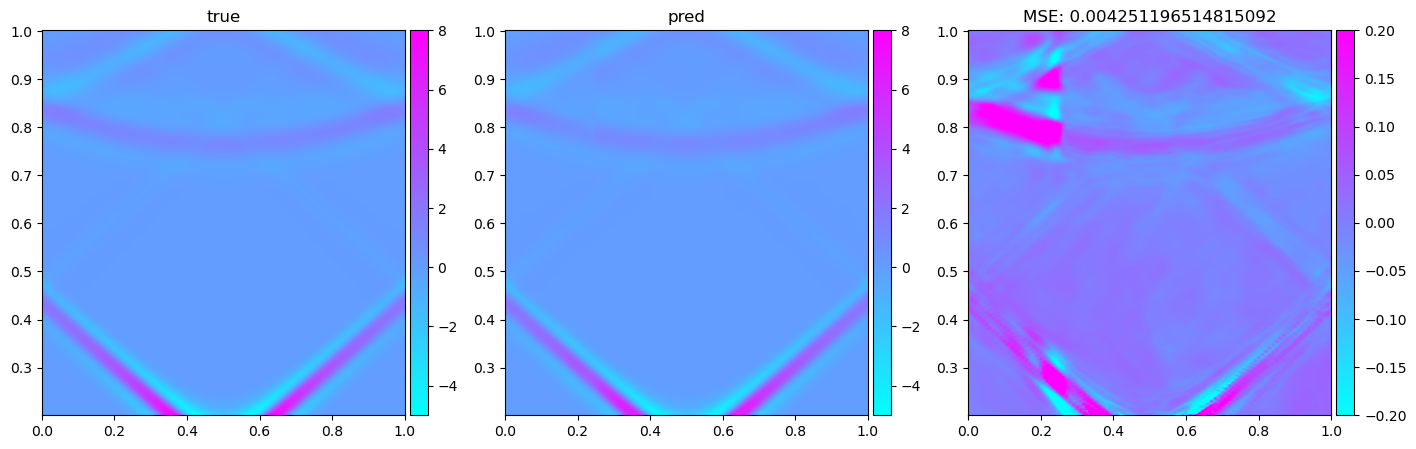

In [15]:
import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=-5.0, vmax=8.0)

X, T = np.meshgrid(x, t_)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p_true, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
im1 = ax[1].contourf(X, T, p_pred, cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
im2 = ax[2].contourf(X, T, p_true - p_pred, cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("MSE: {}".format(np.mean(np.square(p_true - p_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [ ]:
domain = np.array([[0.0, 0.0], [1.0, 1.0]])
def c_fn(x, z):
	return np.piecewise(z, [z >= 0.5, z < 0.5], [2.5, 1.5])

x_test = np.linspace(domain[0, 0], domain[1, 0], 100).reshape((-1, 1))
z_test = np.linspace(domain[0, 1], domain[1, 1], 100).reshape((-1, 1))
xz_test = tensor_grid([x_test, z_test])
xz_test[:, [0, 1]] = xz_test[:, [1, 0]]
c_test = c_fn(xz_test[:, 0:1], xz_test[:, 1:2])

In [ ]:
c_pred = inverse_model(inverse_params, xz_test[:, 0:1], xz_test[:, 1:2]).reshape((-1, 1))

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=1.0, vmax=3.0)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_test.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
im1 = ax[1].contourf(X, Z, c_pred.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-1, vmax=1e-1)
im2 = ax[2].contourf(X, Z, c_test.reshape((len(z_test), len(x_test)))-c_pred.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("MSE: {}".format(np.mean(np.square(c_test - c_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [ ]:
np.max(c_pred)